In [9]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_functions import *
import matplotlib.pyplot as plt
from biotuner.biotuner2d import*
from biotuner.biotuner_object import *
import mne
from scipy import signal
import warnings
import neurokit2 as nk
import pandas as pd
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## Convergent validity of harmonicity metrics

First we will load EEG data. 

In [2]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

We will graph a **correlation matrix using all the harmonicity metrics**. We need to specify which *peaks_function* is being used. We will later compare *peaks_function* with each other. First, let's start with *fixed* bands using **5 bands** spanning **1 octave each**. We will use 250 segments of 3 seconds with a precision of 0.5Hz.

[Text(0, 0.5, 'peaks'),
 Text(0, 1.5, 'cons'),
 Text(0, 2.5, 'harmsim'),
 Text(0, 3.5, 'tenney'),
 Text(0, 4.5, 'spectro_chords'),
 Text(0, 5.5, 'spectro_chords_cons'),
 Text(0, 6.5, 'spectro_chords_cons+'),
 Text(0, 7.5, 'diss_n_steps'),
 Text(0, 8.5, 'dissonance'),
 Text(0, 9.5, 'matrix_cons'),
 Text(0, 10.5, 'matrix_harm_sim'),
 Text(0, 11.5, 'sum_q_for_all_intervals'),
 Text(0, 12.5, 'sum_distinct_intervals'),
 Text(0, 13.5, 'sum_p_q')]

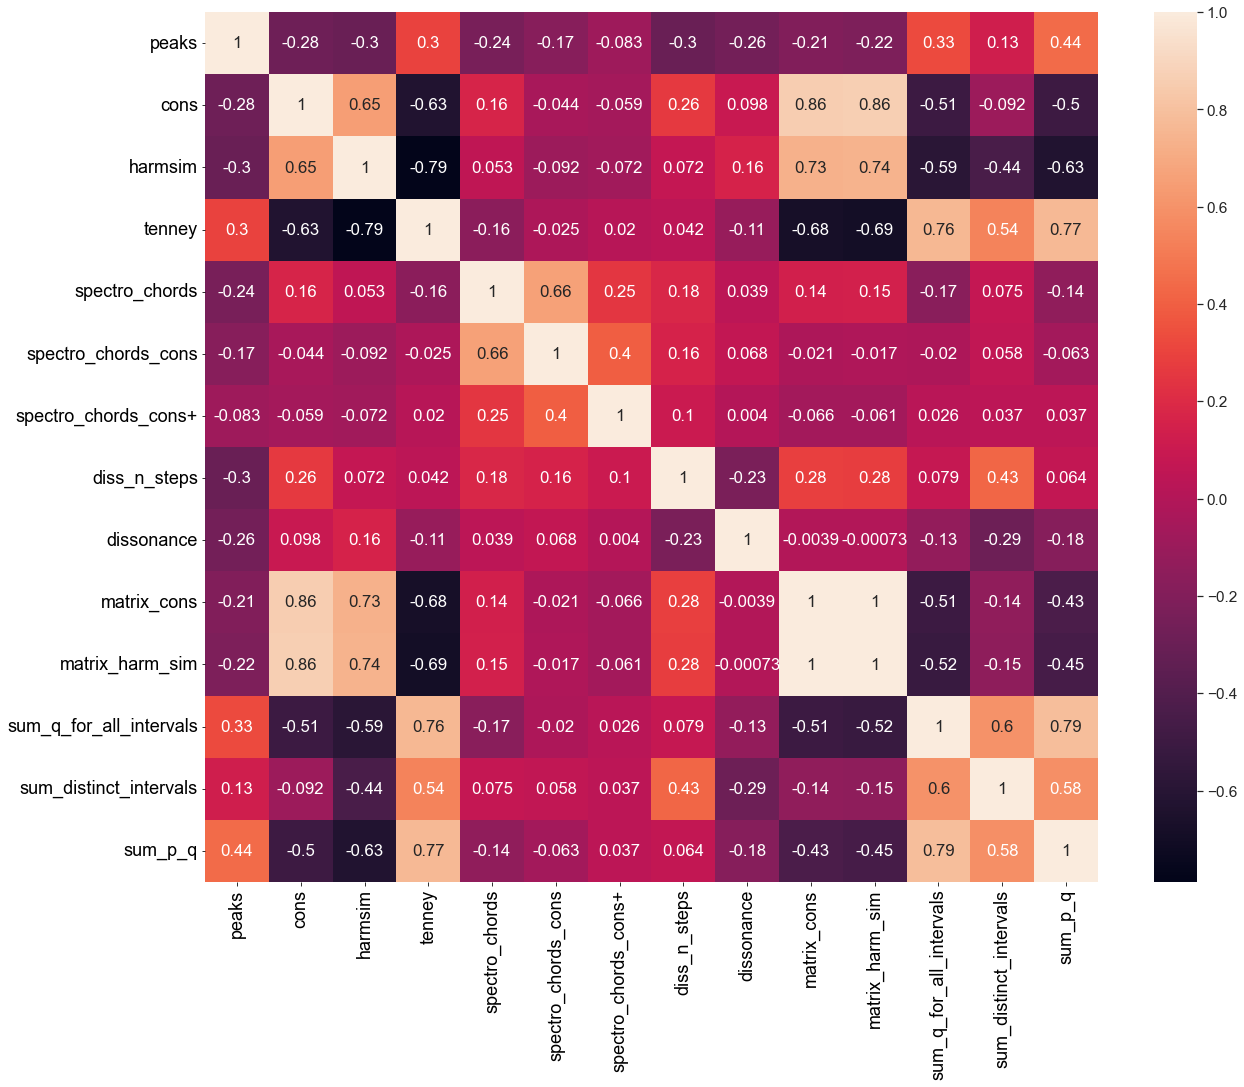

In [3]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='fixed', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)

df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

Let's do the same using Ensemble Empirical Mode Decomposition method (EEMD). 

[Text(0, 0.5, 'peaks'),
 Text(0, 1.5, 'cons'),
 Text(0, 2.5, 'harmsim'),
 Text(0, 3.5, 'tenney'),
 Text(0, 4.5, 'spectro_chords'),
 Text(0, 5.5, 'spectro_chords_cons'),
 Text(0, 6.5, 'spectro_chords_cons+'),
 Text(0, 7.5, 'diss_n_steps'),
 Text(0, 8.5, 'dissonance'),
 Text(0, 9.5, 'matrix_cons'),
 Text(0, 10.5, 'matrix_harm_sim'),
 Text(0, 11.5, 'sum_q_for_all_intervals'),
 Text(0, 12.5, 'sum_distinct_intervals'),
 Text(0, 13.5, 'sum_p_q')]

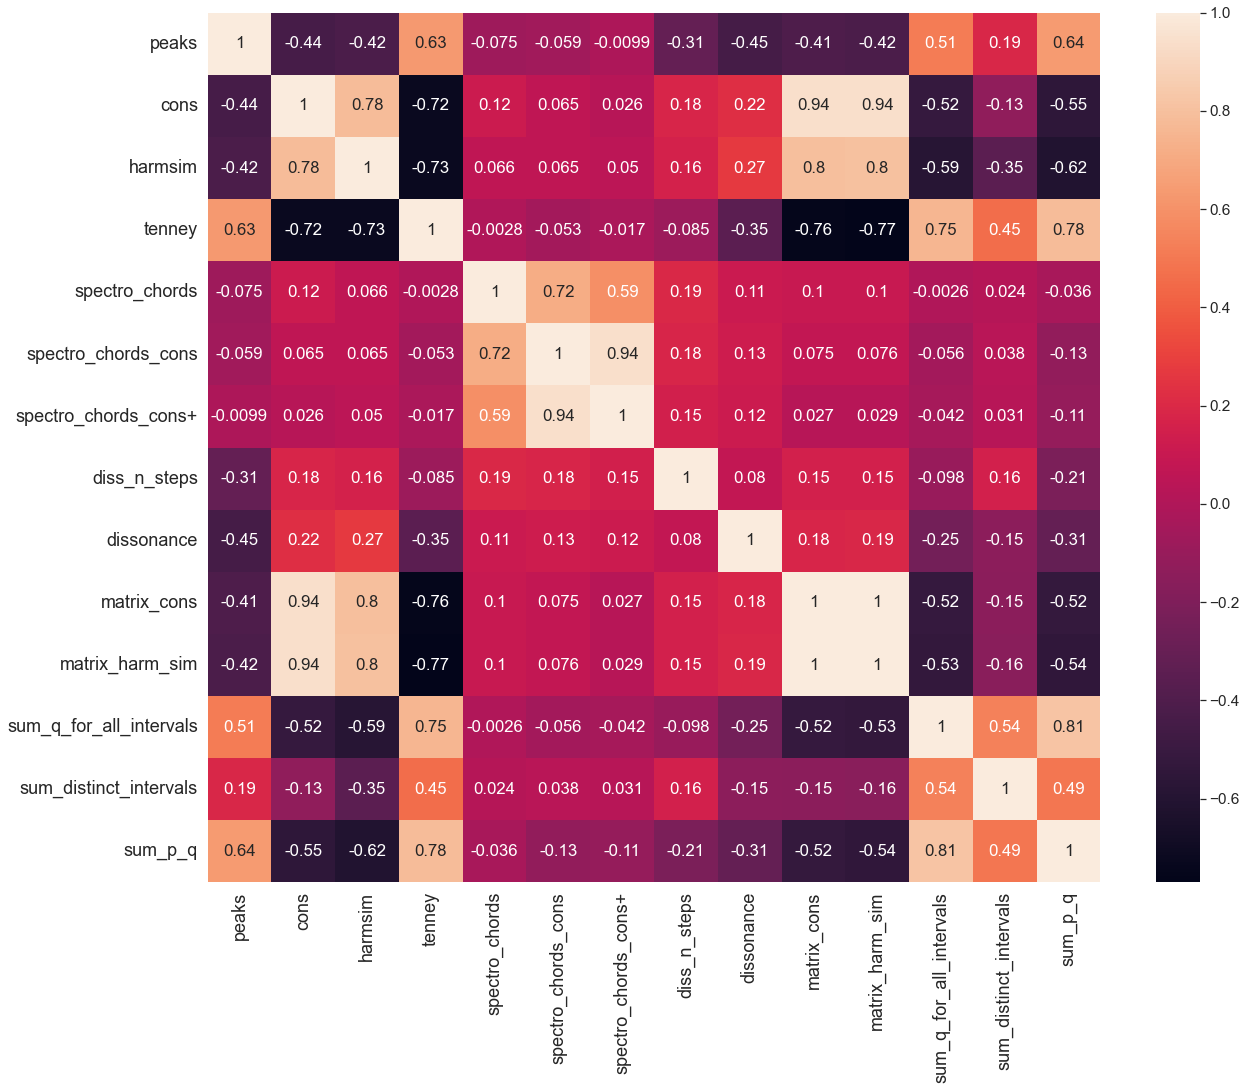

In [4]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
df_metrics = compare_metrics(EEG_data[0:250,2000:5000], 1000, peaks_function='EEMD', precision=0.5,
                            min_notes=3, cons_limit=0.1, chords_multiple_metrics=True, add_cons=0.3, add_notes=2, 
                            FREQ_BANDS = FREQ_BANDS)
df_corr = df_metrics.corr()
fig, ax = plt.subplots(figsize=(20,16))
sbn.set(font_scale=1.4)
res = sbn.heatmap(df_corr, annot=True, cmap='rocket')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)

Since this method uses dyadic filter bank (octave filter bank) to decompose the signal into Intrinsic Mode Functions, we expect that harmonicity metrics might have slightly higher scores as compared to other methods. To test this, we will **plot the average of all metrics for different peak extraction methods**.

The *compare_corr_metrics_peaks* function takes an array of *trials * time_series* and return a dataframe in the shape *peaks_functions * harmonicity_metrics* of the correlation with the averaged peaks frequency (*df_peaks_tot*). 

It also returns a list of dataframes (one per peaks function) in the shape *harmonicity metrics * trials*. (*df_metrics_all*)

In [61]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
df_peaks_EEG, df_metrics_EEG = compare_corr_metrics_peaks(EEG_data[0:250, 2000:5000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_multiple_metrics=True)

harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


Then, we will plot the **average of all metrics correlation** to see if it varies **across peak extraction methods**

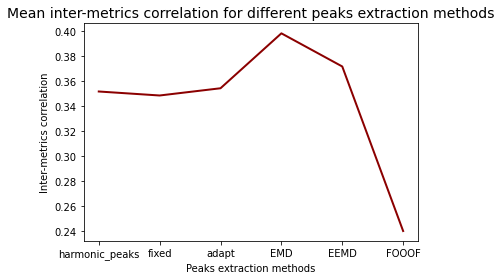

In [86]:
df_metrics_corr_avg = pd.DataFrame()
for method in range(len(df_metrics_all)):
    df_metrics_corr_avg[peaks_functions[method]] = [np.average(abs(df_metrics_all[method].iloc[:, 1:].corr()))]


plt.plot(df_metrics_corr_avg.loc[0], color='darkred', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.show()
#df_metrics_corr_avg

We will do the same but with a peak precision of **0.1Hz** instead of 0.5Hz to see if the results are constant

In [95]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
df_peaks_EEG2, df_metrics_EEG2 = compare_corr_metrics_peaks(EEG_data[0:250, 4000:9000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=3, cons_limit=0.1, chords_multiple_metrics=True)

harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


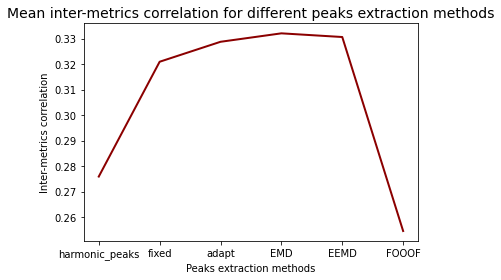

In [96]:
df_metrics_corr_avg = pd.DataFrame()
for method in range(len(df_metrics_EEG2)):
    df_metrics_corr_avg[peaks_functions[method]] = [np.average(abs(df_metrics_EEG2[method].iloc[:, 1:].corr()))]


plt.plot(df_metrics_corr_avg.loc[0], color='darkred', linewidth=2)
plt.title('Mean inter-metrics correlation for different peaks extraction methods', fontsize=14)
plt.xlabel('Peaks extraction methods')
plt.ylabel('Inter-metrics correlation')
plt.show()
#df_metrics_corr_avg

## How do harmonicity metrics are affected by averaged frequency values ?

Since the *Biotuner* computes hamonicity metrics on frequency peaks, we want to observe how these metrics correlate with the averaged frequencyof their input. In other words, **are lower frequencies more consonant than higher frequencies ?** 

To answer this question, we will look at how the correlation between mean frequency and harmonicity metrics varies across peak extraction methods.

In [273]:
df_sorted_EEG = df_peaks_EEG.sort_values(by = ['EEMD', 'EMD', 'fixed', 'adapt', 'FOOOF', 'harmonic_peaks'])
df_sorted_EEG = df_sorted_EEG #we remove the correlation of peaks with peaks (always equals 1)

<function matplotlib.pyplot.show(close=None, block=None)>

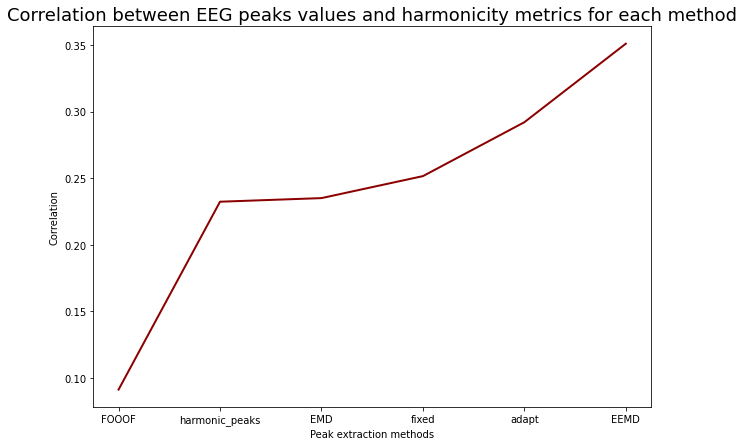

In [89]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=0).sort_values(), color = 'darkred', linewidth=2)
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics for each method', fontsize=18)
plt.xlabel('Peak extraction methods')
plt.ylabel('Correlation')
plt.show

Here we explore how harmonicity metrics correlate with frequency peaks in average of all peak extraction methods

<function matplotlib.pyplot.show(close=None, block=None)>

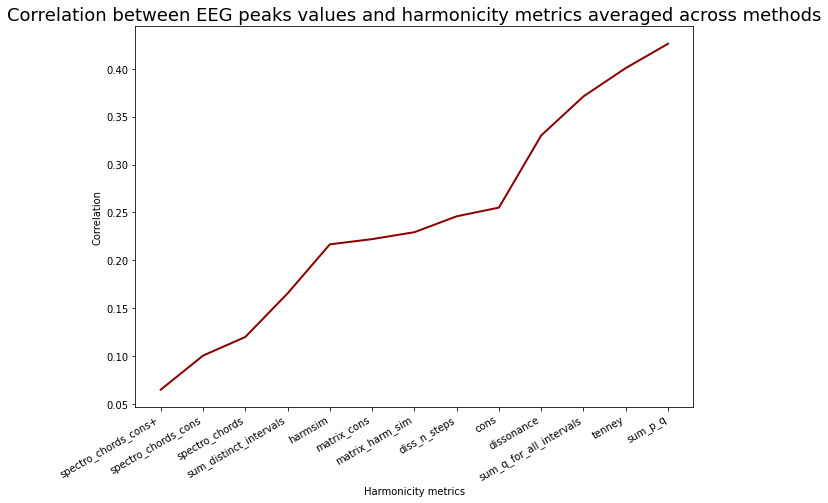

In [90]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=1).sort_values(), color = 'darkred', linewidth=2)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

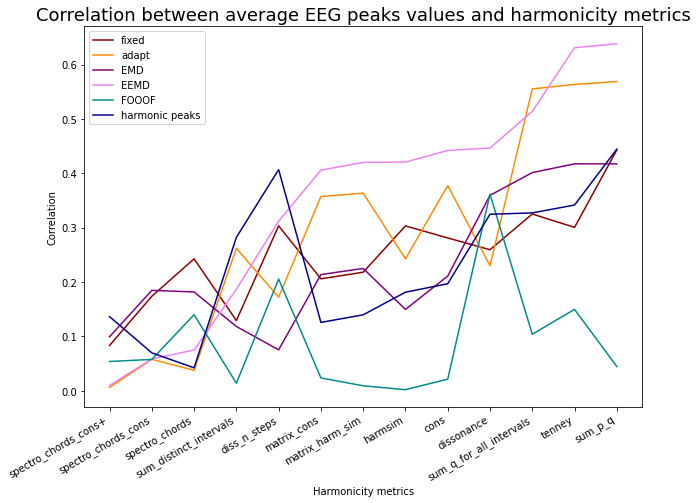

In [93]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG['fixed'], color='darkred', label="fixed")
plt.plot(df_sorted_EEG['adapt'], color='darkorange', label="adapt")
plt.plot(df_sorted_EEG['EMD'], color='purple', label="EMD")
plt.plot(df_sorted_EEG['EEMD'], color='violet', label="EEMD")
plt.plot(df_sorted_EEG['FOOOF'], color='darkcyan', label="FOOOF")
plt.plot(df_sorted_EEG['harmonic_peaks'], color='darkblue', label="harmonic peaks")
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between average EEG peaks values and harmonicity metrics', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

### We will do the same analyses with peaks precision at 0.1Hz

In [97]:
df_sorted_EEG2 = df_peaks_EEG2.sort_values(by = ['EEMD', 'EMD', 'fixed', 'adapt', 'FOOOF', 'harmonic_peaks'])
df_sorted_EEG2 = df_sorted_EEG2.iloc[:-1] #we remove the correlation of peaks with peaks (always equals 1)

harmonic_peaks     fixed     adapt       EMD  \
spectro_chords_cons            0.281161  0.193293  0.002376  0.077057   
spectro_chords_cons+           0.052800  0.059765  0.099957  0.118170   
sum_distinct_intervals         0.033458  0.096621  0.139295  0.126917   
spectro_chords                 0.328876  0.203265  0.013070  0.021922   
diss_n_steps                   0.217241  0.319033  0.092513  0.136091   
matrix_cons                    0.083710  0.097361  0.196131  0.228430   
harmsim                        0.037962  0.000147  0.186842  0.203409   
cons                           0.027475  0.066709  0.309177  0.281221   
matrix_harm_sim                0.068448  0.107797  0.229488  0.243612   
dissonance                     0.523427  0.333035  0.571889  0.379238   
tenney                         0.336392  0.041733  0.463407  0.432930   
sum_q_for_all_intervals        0.048480  0.170992  0.435472  0.419603   
sum_p_q                        0.024652  0.276294  0.516670  0.393263   

                             EEMD     FOOOF  
spectro_chords_cons      0.030449  0.252348  
spectro_chords_cons+     0.045577  0.192623  
sum_distinct_intervals   0.060859  0.515667  
spectro_chords           0.068899  0.326392  
diss_n_steps             0.180111  0.195716  
matrix_cons              0.190118  0.037248  
harmsim                  0.193363  0.037097  
cons                     0.196541  0.064264  
matrix_harm_sim          0.197023  0.051979  
dissonance               0.358474  0.033127  
tenney                   0.365539  0.001507  
sum_q_for_all_intervals  0.397922  0.199739  
sum_p_q                  0.417104  0.113815

<function matplotlib.pyplot.show(close=None, block=None)>

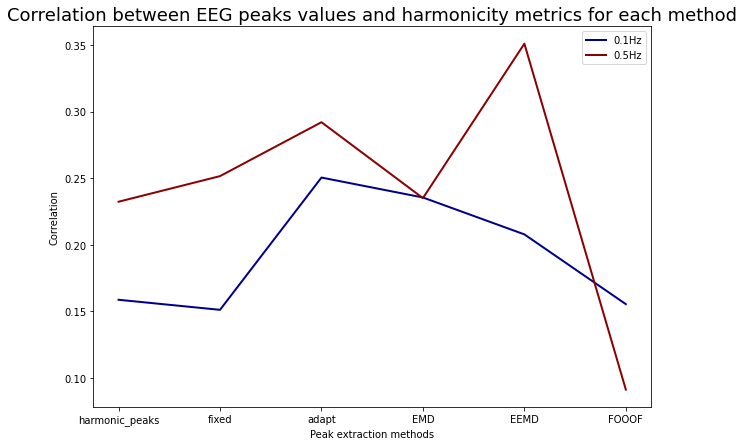

In [123]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG2.mean(axis=0), color = 'darkblue', linewidth=2, label='0.1Hz')
plt.plot(df_sorted_EEG.mean(axis=0), color = 'darkred', linewidth=2, label='0.5Hz')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics for each method', fontsize=18)
plt.legend()
plt.xlabel('Peak extraction methods')
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

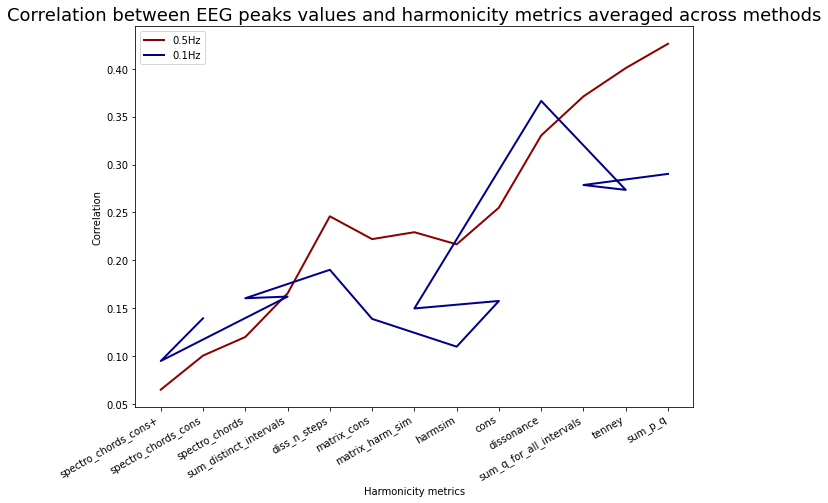

In [124]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG.mean(axis=1), color = 'darkred', linewidth=2, label='0.5Hz')
plt.scatter(df_sorted_EEG2.mean(axis=1), color = 'darkblue', linewidth=2, label='0.1Hz')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

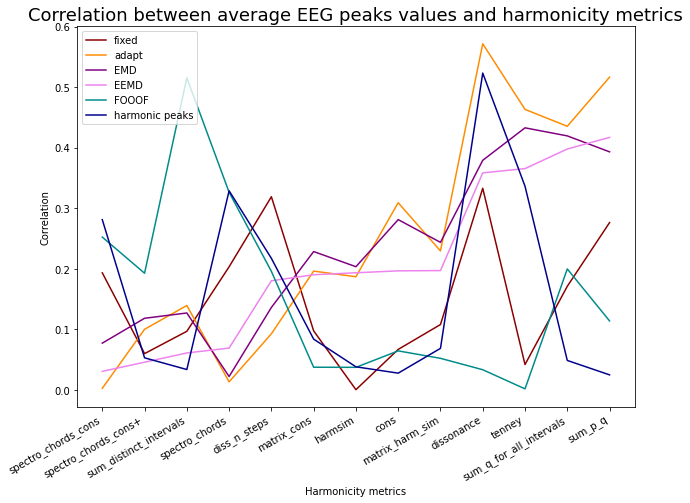

In [100]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(df_sorted_EEG2['fixed'], color='darkred', label="fixed")
plt.plot(df_sorted_EEG2['adapt'], color='darkorange', label="adapt")
plt.plot(df_sorted_EGG2['EMD'], color='purple', label="EMD")
plt.plot(df_sorted_EEG2['EEMD'], color='violet', label="EEMD")
plt.plot(df_sorted_EEG2['FOOOF'], color='darkcyan', label="FOOOF")
plt.plot(df_sorted_EEG2['harmonic_peaks'], color='darkblue', label="harmonic peaks")
plt.legend(loc='upper left')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between average EEG peaks values and harmonicity metrics', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.show

## Which harmonicity metrics best distinguish between EEG and ECG ?

In [10]:
#ECG
path = 'data_examples/ECG/'
data = mne.io.read_raw_edf(path + '/r01.edf', preload = True)
ECG_data = data.load_data()
ECG_data = ECG_data.get_data()
ECG_sf = 1000
ECG_data = slice_data(ECG_data[0:4], ECG_sf, window=5)
ECG_data.shape
EEG_data, ECG_data = equate_dimensions(EEG_data, ECG_data)


Extracting EDF parameters from C:\Users\Dell\GitHub\biotuner\examples\data_examples\ECG\r01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 299999  =      0.000 ...   299.999 secs...


NameError: name 'slice_data' is not defined

In [294]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'FOOOF', 'FOOOF_EEMD', 'cepstrum']
peaks_corr_ECG, ECG_metrics = compare_corr_metrics_peaks(ECG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

ECG_metrics = np.array(ECG_metrics)
EEG_metrics = np.array(EEG_metrics)

HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF
HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


We will look at how the correlation between peak frequencies and harmonicity metrics differs between ECG and EEG

<function matplotlib.pyplot.show(close=None, block=None)>

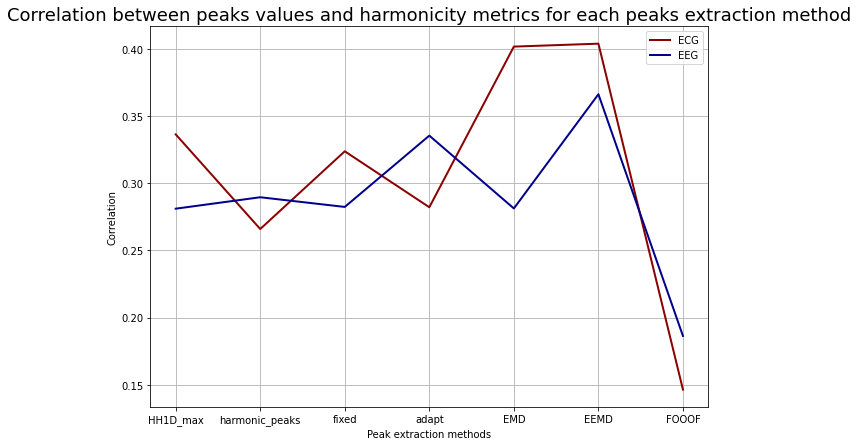

In [353]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=0), color = 'darkred', linewidth=2, label="ECG")
plt.plot(peaks_corr_EEG.mean(axis=0), color = 'darkblue', linewidth=2, label='EEG')
#plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between peaks values and harmonicity metrics for each peaks extraction method', fontsize=18)
plt.xlabel('Peak extraction methods')
plt.legend()
plt.grid()
plt.ylabel('Correlation')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

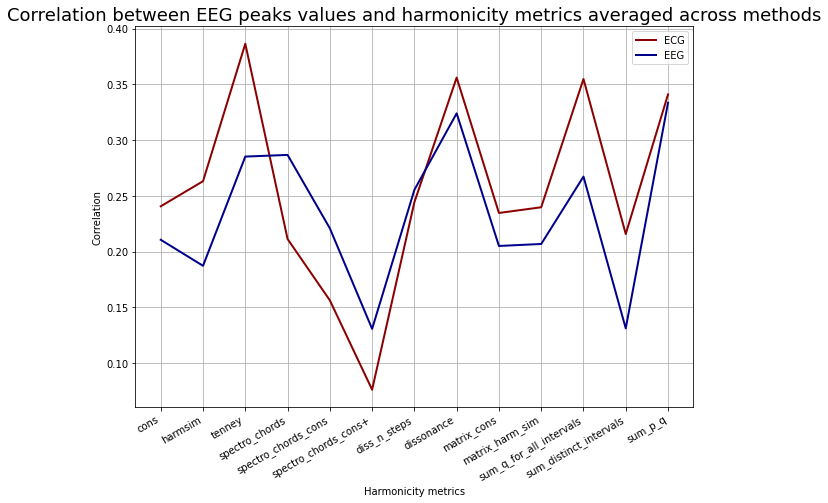

In [355]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(peaks_corr_ECG.mean(axis=1)[1:], color = 'darkred', linewidth=2, label='ECG')
plt.plot(peaks_corr_EEG.mean(axis=1)[1:], color = 'darkblue', linewidth=2, label='EEG')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Correlation between EEG peaks values and harmonicity metrics averaged across methods', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('Correlation')
plt.grid()
plt.legend()
plt.show

### We will evaluate with t tests which harmonicity metrics and peaks extraction functions best distinguish between ECG and EEG signals

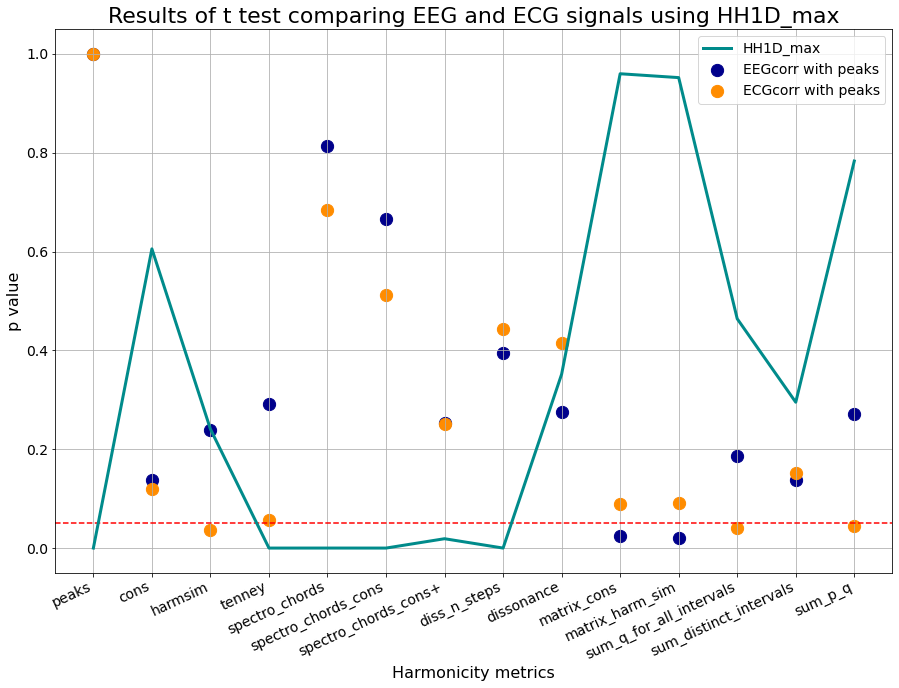

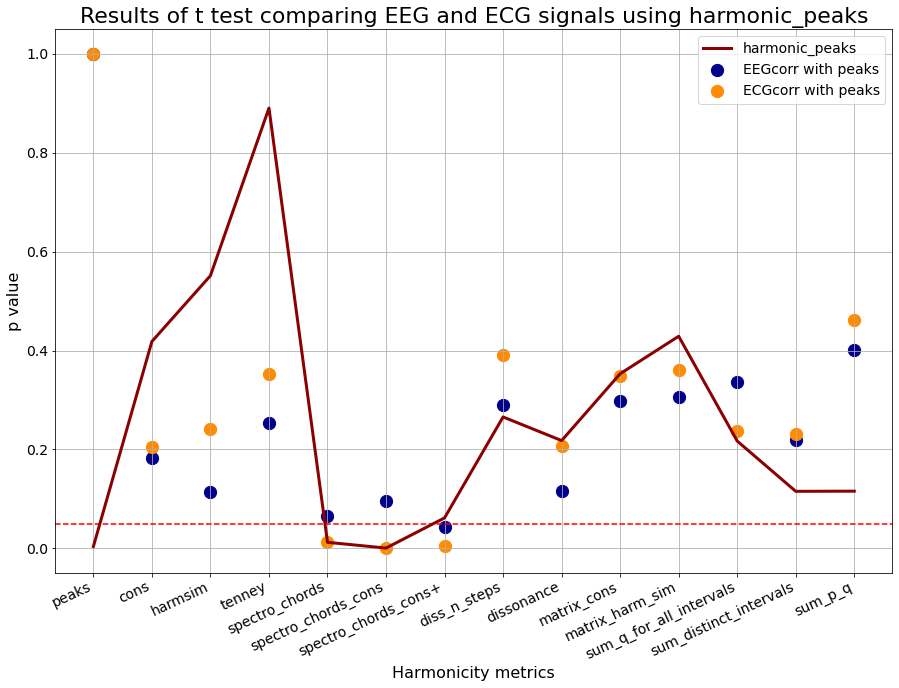

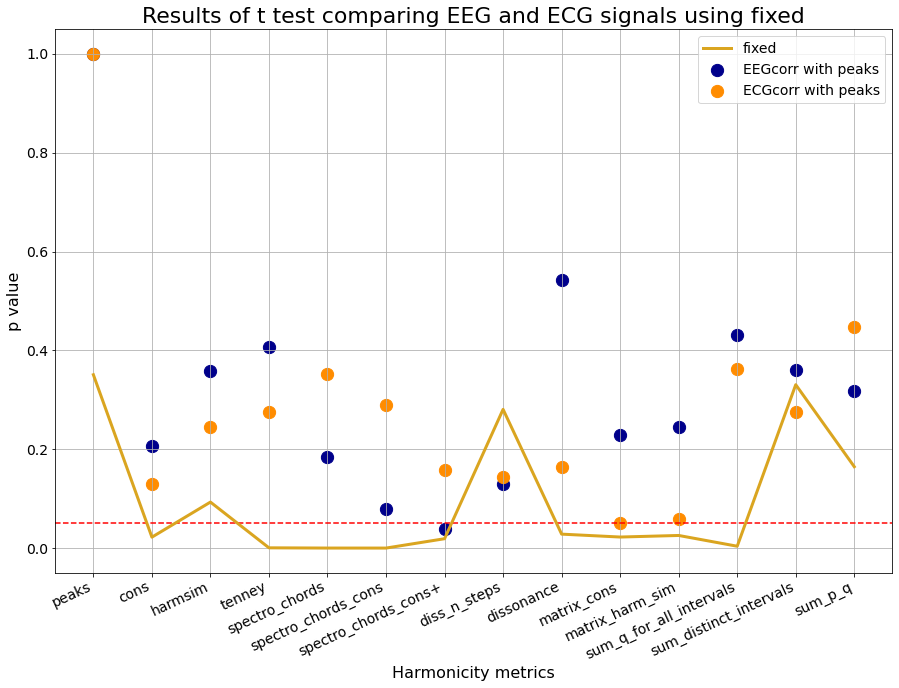

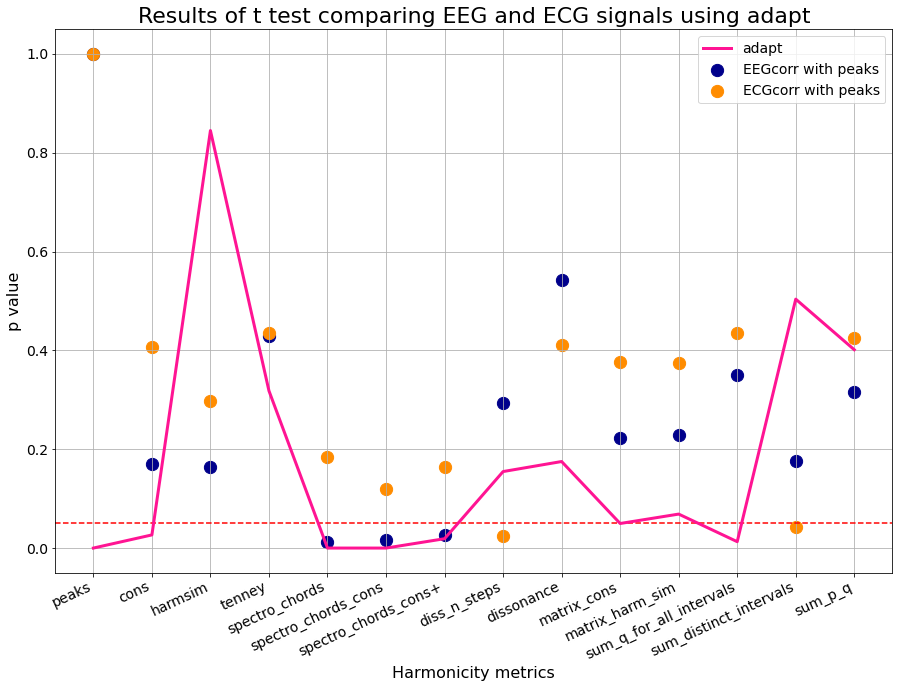

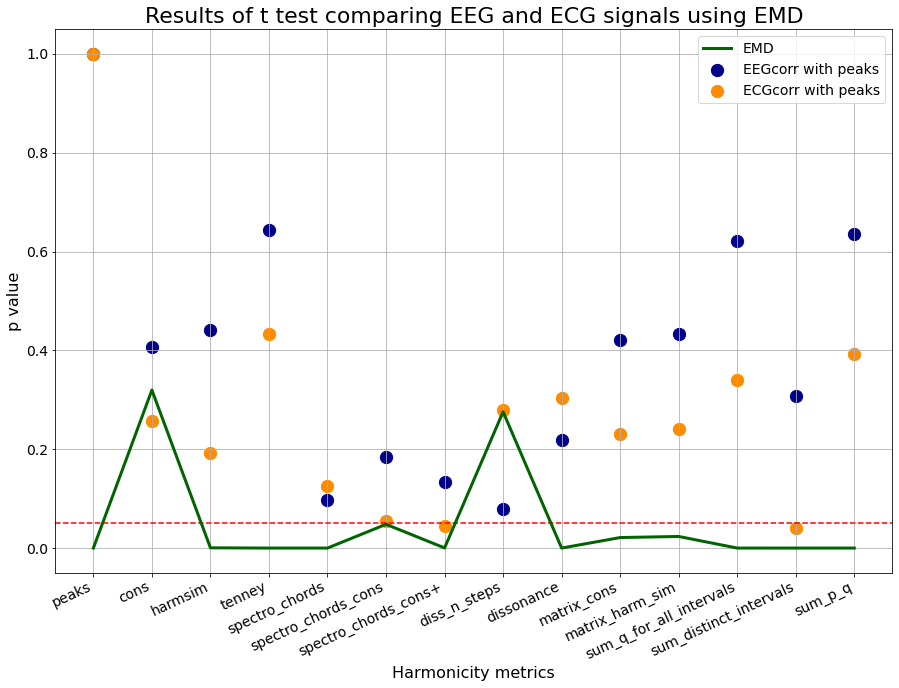

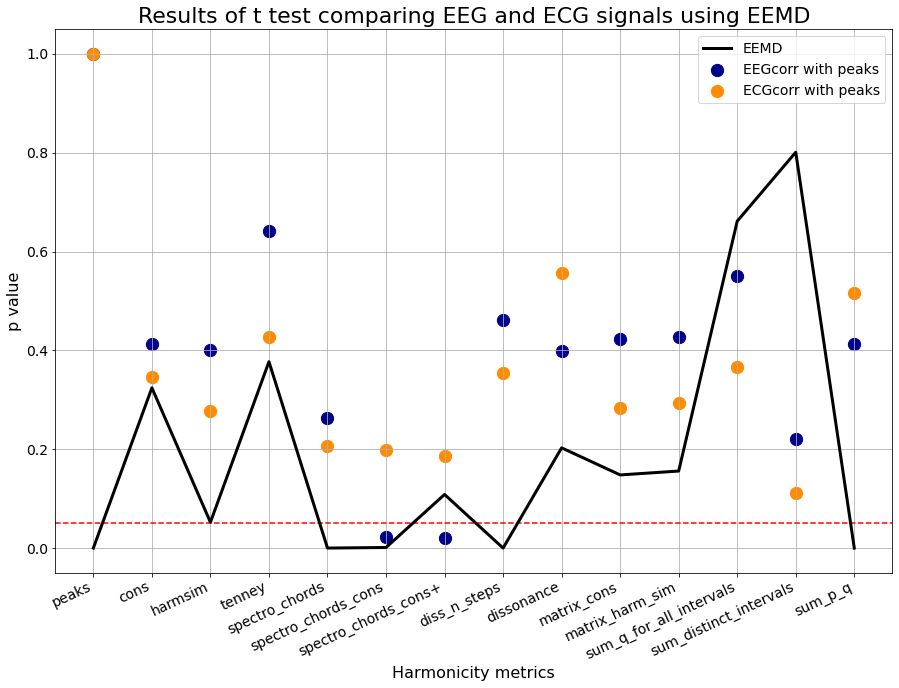

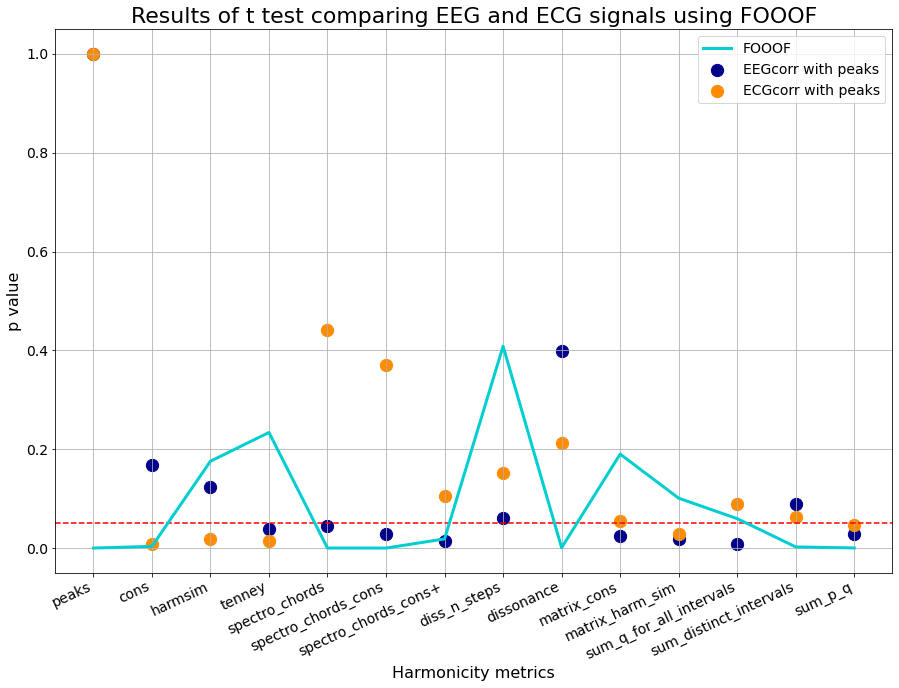

In [343]:
ttest_all = ttest_all_metrics(ECG_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all, function, labels = ['EEG', 'ECG'], 
                           peaks_corr1=peaks_corr_ECG, peaks_corr2=peaks_corr_EEG, color=color, save=True)

<function matplotlib.pyplot.show(close=None, block=None)>

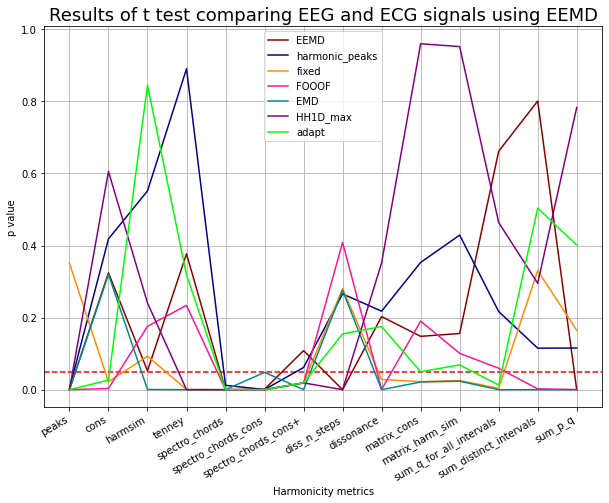

In [361]:
fig, ax = plt.subplots(figsize=(10,7))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('Results of t test comparing EEG and ECG signals using EEMD', fontsize=18)
plt.xlabel('Harmonicity metrics')
plt.ylabel('p value')
plt.axhline(y=0.05, color='r', linestyle='--')

plt.plot(ttest_all['EEMD'], color='darkred', label='EEMD')
plt.plot(ttest_all['harmonic_peaks'], color='darkblue', label='harmonic_peaks')
plt.plot(ttest_all['fixed'], color='darkorange', label='fixed')
plt.plot(ttest_all['FOOOF'], color='deeppink', label='FOOOF')
plt.plot(ttest_all['EMD'], color='darkcyan', label='EMD')
plt.plot(ttest_all['HH1D_max'], color='purple', label='HH1D_max')
plt.plot(ttest_all['adapt'], color='lime', label='adapt')
plt.grid()
plt.legend()
plt.show

<BarContainer object of 7 artists>

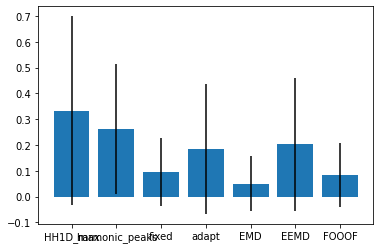

In [394]:
plt.bar(list(ttest_all.head()), ttest_all.mean(axis=0), yerr=ttest_all.std(axis=0))

## Which harmonicity metrics best distinguish between EEG and pink noise ?

In [4]:
path = 'C:/Users/Dell/GitHub/biotuner/examples/data_examples/'
EEG_data = np.load(path+'parei_data_1000ts.npy')
EEG_sf = 1000
EEG_data.shape

(500, 9501)

In [5]:
pink_data = surrogate_signal_matrices(EEG_data[0:250, 2000:7000], surr_type = 'pink', low_cut = 0.5, high_cut = 150, sf = 1000)

In [5]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['FOOOF', 'fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'HH1D_max', 'FOOOF_EEMD']
peaks_corr_pink, pink_metrics = compare_corr_metrics_peaks(pink_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)
peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)


FOOOF
[2.9800180197563977, 5.299992481220762, 8.051841193702913, 11.129250765114573, 13.847395183713157, 16.62331974081643, 18.32623040779386, 22.647626908612317, 24.943146310868723, 29.65343781045155, 31.45474819062941, 37.824669788389876, 44.024799042581044]
[1.590624807966881, 3.2431808177180645, 6.368260025562976, 12.158657067364876, 17.84046228068679, 22.681670062539126, 30.42002948755761, 34.34068943678357, 39.102566563372754, 42.8698543178834]
[3.865101370670614, 6.447040161123152, 10.387030229626124, 13.753657841833727, 16.713171731556393, 20.658194747780726, 28.109496719150673, 30.96221209515629, 32.4021762232453, 39.60451639498594, 43.251208051397946]
[3.1711960432233104, 10.830566054395858, 13.02979119131992, 18.361477322488447, 30.75582591692491, 34.917681852302884]
[1.4018167101070647, 6.080931665900201, 9.616333059415792, 15.422319729740016, 20.945030145929934, 26.710766206926856, 33.965980851218376, 37.89334566980853, 41.26845605005039]
[3.5364131427905647, 12.6321330548

[7.056840108396856, 19.91883628783031, 34.9740126816459, 42.66876713085055]
[3.5947287529336536, 5.259220792111743, 9.439923936547485, 17.039208764531573, 19.461492905758934, 28.52268339838806, 32.72361243427041, 37.45985168425123, 39.8200311180678, 44.26185623789563]
[3.546581874449593, 15.167966470994653, 16.698408290524966, 18.959110158157163, 28.46509189770735, 33.571566874348264, 36.966178836399784, 38.427775254088125, 42.595180786262674]
[7.762091835401822, 15.285256129896599, 19.87508792976683, 26.78965975987223, 36.805812514942595, 42.97239137599644]
[6.941228126861196, 11.674115389080656, 15.71499242284619, 19.899372049197382, 28.215081880297554]
[2.2843924692598994, 4.148229681808464, 7.337672187012048, 12.520263317091961, 15.521152036416746, 17.145513065236422, 22.320761283196646, 33.52393866793558, 40.36081486068908, 42.00561047492018]
[2.1557358696203894, 5.4344781605045664, 11.491630050459177, 16.214981913152798, 21.68279377690143, 26.008392140514214, 29.515371492575614, 

[2.1584690135959628, 4.43296711714293, 7.90016092776385, 13.813561487829359, 15.994713793525365, 20.86854743073575, 27.780637027740426, 33.497734909909134]
[2.9138428073750124, 4.931389195670828, 9.341692882643128, 12.003194652273928, 14.750342662537372, 18.99334730354984, 26.72368465491628, 35.62951161966586, 39.09384354638496, 42.9102576595112]
[5.760186860291963, 9.02834718851445, 15.561097495168191, 24.062908935218815, 27.318353295396033, 30.211321406413667, 32.83629952842959, 36.5479654008637]
[2.3659403022904786, 6.86472007502503, 10.124133790205747, 14.89698140132616, 27.41007830263706, 42.23222431659036]
[1.4024080123816516, 3.2638413632785523, 5.605509531726064, 10.244983738908536, 13.00976100678083, 18.47849323301537, 21.724918064288335, 35.66789165488682]
[1.8545590363407316, 3.404993682487943, 8.463046480560783, 12.501587011284435, 18.314072908522142, 20.122127281503968, 23.04598988163045, 31.2206284309483, 36.83737093158626, 39.581522914302404]
[5.787162518460058, 9.850356

[5.060578073307529, 8.525395322906865, 8.585218936220617, 13.128296284415939, 14.971575110095888, 21.400324505850794, 24.696418757916714, 26.439190780494318, 31.460818821007734, 33.728524810110194, 39.64940945092642, 41.04606681231385]
[7.423667407821715, 12.04434337510529, 16.33984872945161, 21.637584841404543, 25.200198442713877, 34.21123857070042, 37.41193544707543, 39.738041935620956, 42.04249643237984]
[24.076941099822914, 28.041792873413307, 42.770424635483394]
[2.66274678043888, 6.544851534725268, 11.691098740790167, 15.651834680161334, 19.42952140001091, 24.3001549525673, 28.721407596126472, 31.12593796473959, 33.3120326237303, 36.88739450905127, 40.37123002661301, 43.174087497831955]
[15.05986201256289, 22.010521759208018, 29.93884455488249, 33.0124577813443, 42.91192777384422]
[6.2450964832189975, 10.30660931028827, 14.07533772808929, 17.633311919457423, 21.677207795248286, 26.862123787354687, 32.167276884650775, 34.640349877036044, 41.492996450514376]
[3.5540084726636723, 5.

[1.4591602918552804, 2.93671728062809, 4.3598580469930965, 7.999344723961053, 15.890820259291715, 19.853208807072175, 21.822660078628157, 28.74059673450056, 30.29133473706181, 32.84784702844921, 37.7265894898934, 43.89751383061229]
[9.124390315607645, 15.151592159651326, 26.452072603045956, 28.163867585386036, 36.53142298287126, 39.96080787445632, 43.698125270132735]
[4.798070823009237, 14.396273593108058, 19.61747314215938, 30.669226841443173, 34.37049102001337, 41.27177939709927]
[1.958581149458214, 6.419694601375152, 16.0827529066125, 18.846224029530227, 20.900962927492305, 29.55302250833629, 32.107252243884815, 34.53362135550537, 36.870949439847756, 41.6931970536919]
[3.930729858360875, 7.499999999999999, 13.112665541675767, 14.779190459539933, 20.26816553066434, 22.288031277097325, 31.294262734200814, 34.371344252588294]
[3.0692276326553976, 6.540299403656333, 13.02643895853349, 17.429568620810173, 18.91995883587472, 23.033475275061555, 27.572183051219405, 34.06180013740897, 38.60

[1.5501590159322136, 5.936378275509926, 8.567698314196434, 13.553472023215065, 18.69774624785732, 28.593306159868213, 37.923794448947525, 43.444116365764806]
[5.99243639040575, 9.329612091555806, 11.866486397037612, 22.830652312151912, 28.02264751909122, 31.64499180241797, 41.34913545366078]
[3.586551055204775, 4.810478514551382, 6.37563341340099, 8.91761313820475, 23.212205239205936, 25.72033894783632, 28.103956463946076, 31.793674365227577, 34.56934745316238, 40.1397662422434, 43.364678325627004]
[4.33874617833517, 8.71665042002394, 11.931849872951595, 13.188374207697041, 15.39852321453628, 20.49625896647179, 22.378923005604577, 26.31996479801918, 27.278067294108272, 29.777527941442877, 31.802092874977973, 34.77304762640874, 37.77953480409912, 39.950540777361645, 42.178291891701384]
[7.243767193166394, 11.74620144259761, 18.898544038300734, 21.515162425800952, 28.599064504657477, 32.3583805310496, 38.114309005268304]
fixed
adapt
cepstrum
harmonic_peaks
HH1D_max
FOOOF_EEMD


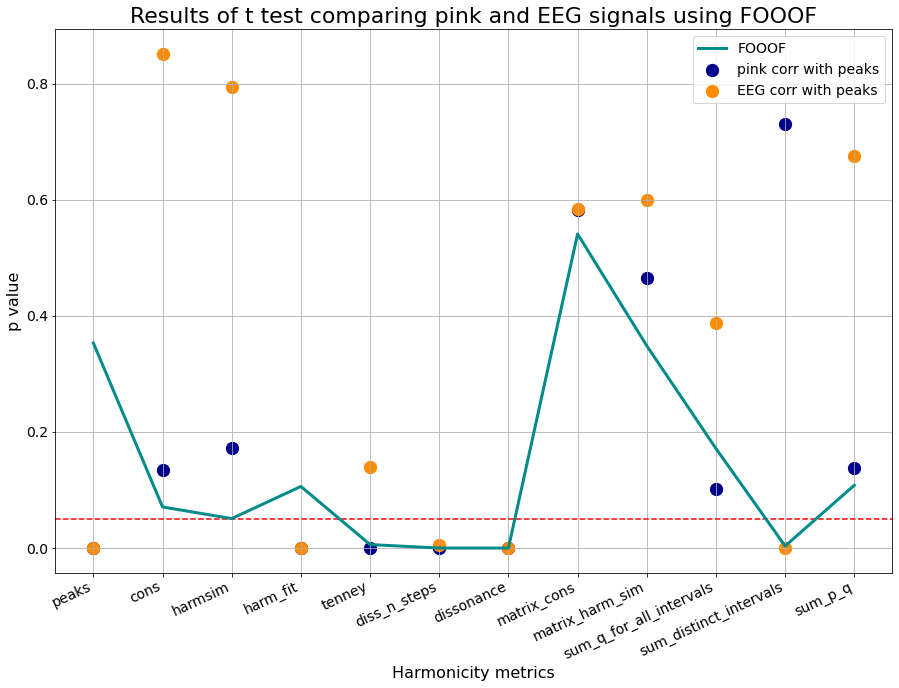

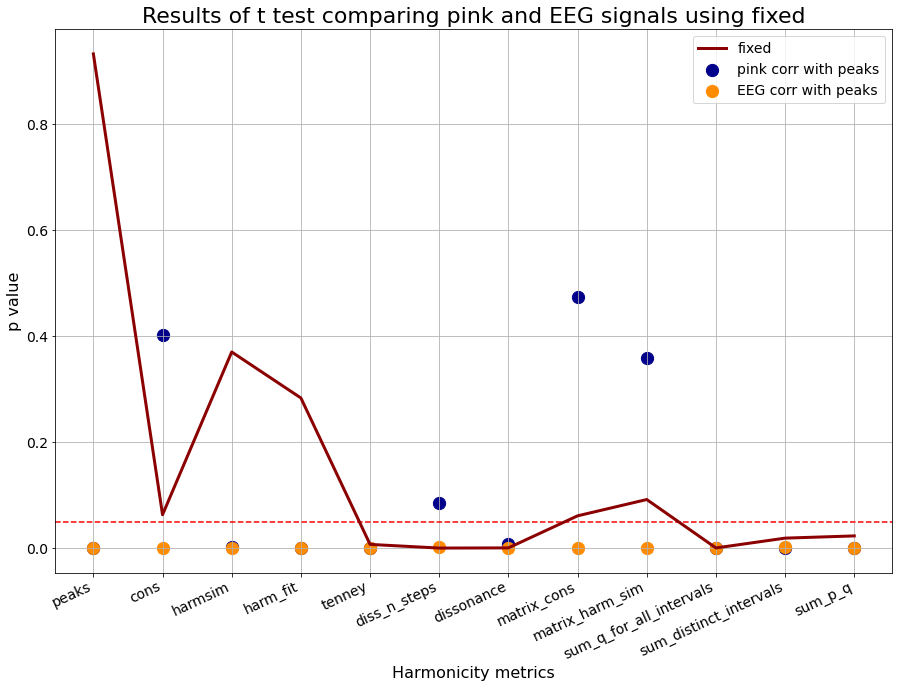

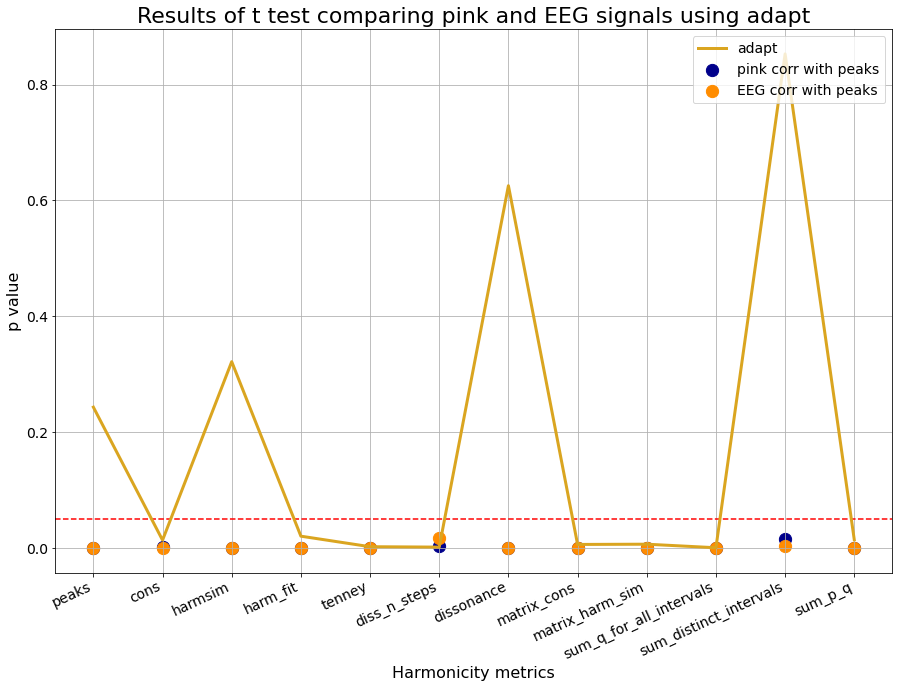

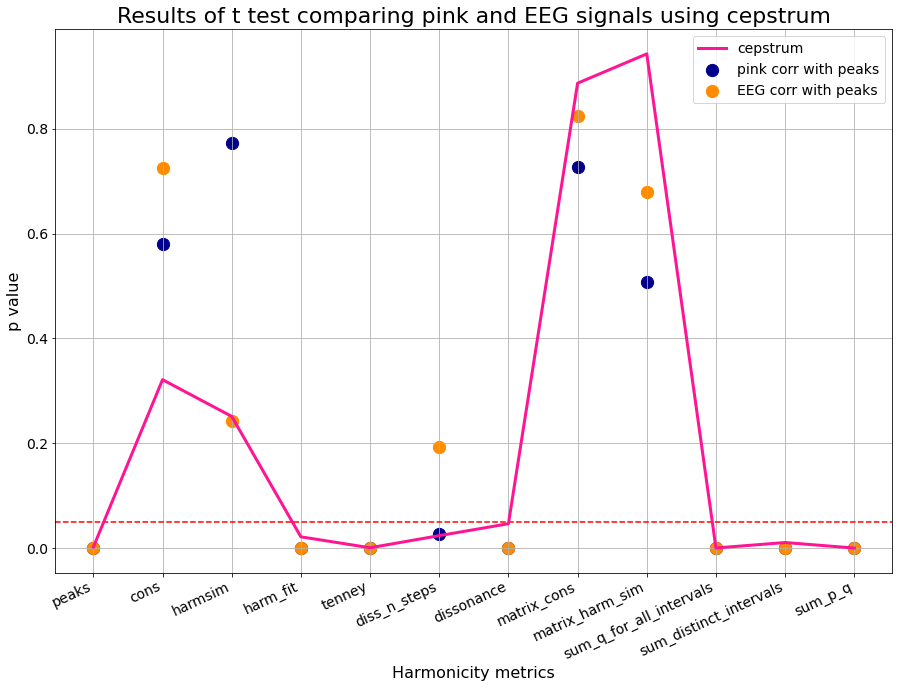

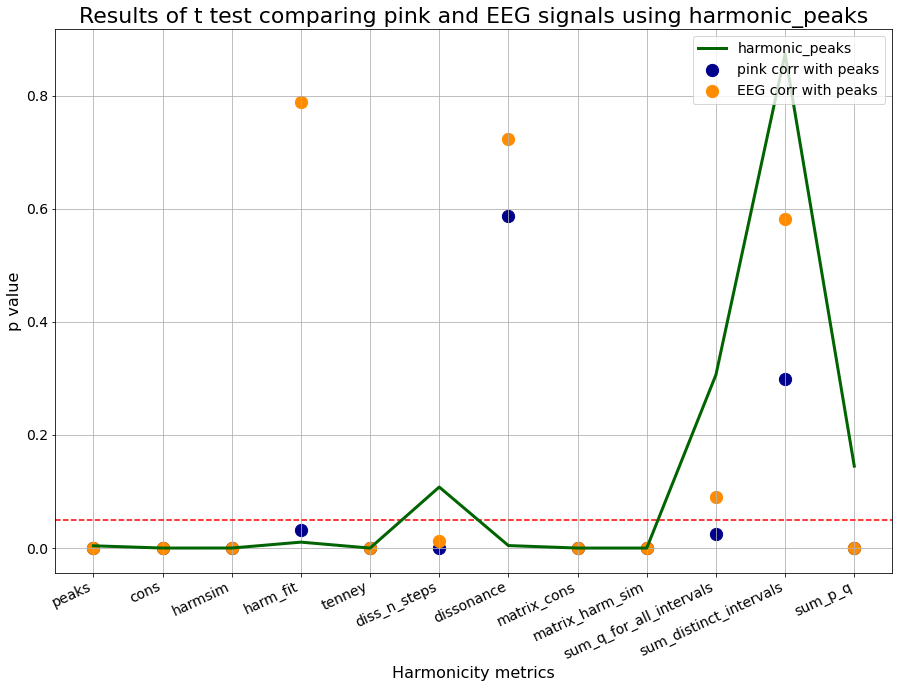

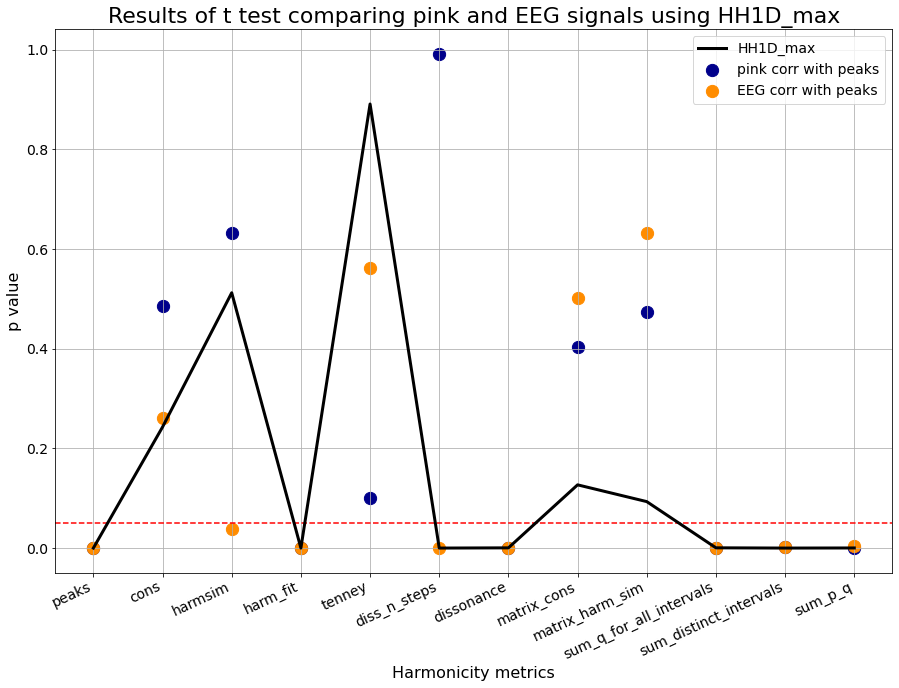

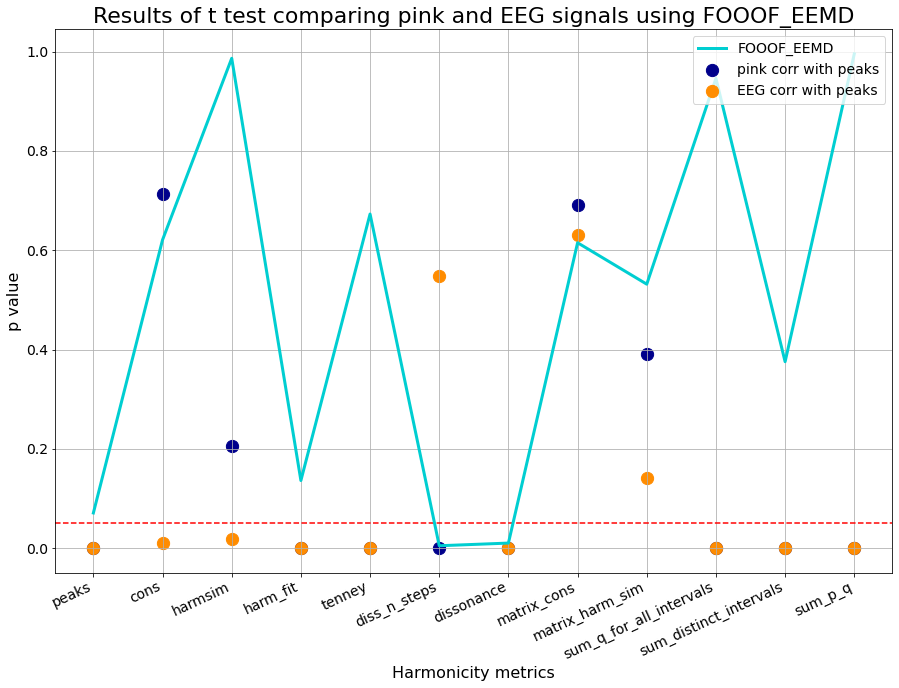

In [7]:
ttest_all_EEG_pink = ttest_all_metrics_all_functions(pink_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_pink, function, labels = ['pink', 'EEG'], 
                           peaks_corr1=peaks_corr_pink, peaks_corr2=peaks_corr_EEG, color=color, save=True)

In [ ]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['FOOOF', 'fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'HH1D_max', 'FOOOF_EEMD']
peaks_corr_pink, pink_metrics = compare_corr_metrics_peaks(pink_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)
peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.1, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)


FOOOF
[2.500694480509007, 5.235410617978468, 8.229766457245743, 10.198911776570135, 10.795897553725448, 11.640411490440618, 13.558828170036065, 14.50959308017204, 16.374045956588027, 18.109690222216347, 19.04904010858985, 19.79886527260792, 20.562970693774297, 22.44529327647182, 23.16936479192777, 23.839599076796432, 24.85401901084732, 26.712120150470664, 29.400059619193083, 30.191799770479772, 31.258886262710654, 32.11104716747336, 34.419116069072096, 37.19187419933653, 37.69075353036244, 38.325068148334005, 42.66400480453476, 43.93695938559313]
[1.4501428138252075, 3.0394159270011487, 3.896516557640185, 5.684141516418961, 9.19797630316492, 17.70317786638889, 18.726985798171054, 19.85532813509453, 22.30418827928317, 22.48499041379114, 23.60349659515782, 25.053803907922603, 26.02926401724112, 26.613878268427033, 29.41972397258075, 31.560952173174364, 34.10050640238409, 37.155659737983044, 39.188947141796824, 39.86268333130217, 40.533878757943576]
[0.6465399733144159, 1.3322566043614037

In [6]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions = ['EMD', 'EEMD']
peaks_corr_pink, pink_metrics = compare_corr_metrics_peaks(pink_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)
peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

EMD
EEMD
EMD
EEMD


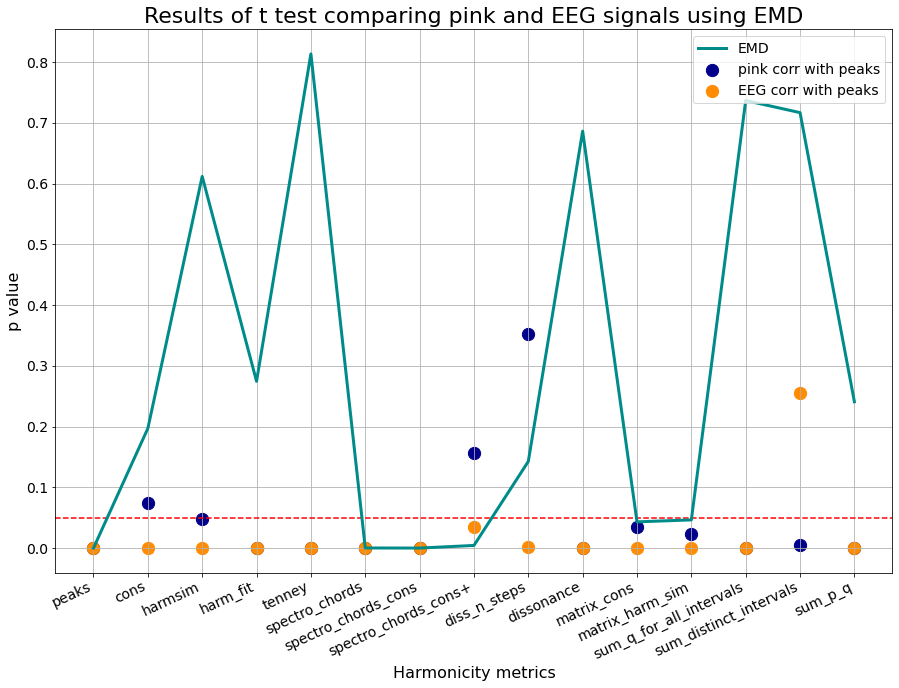

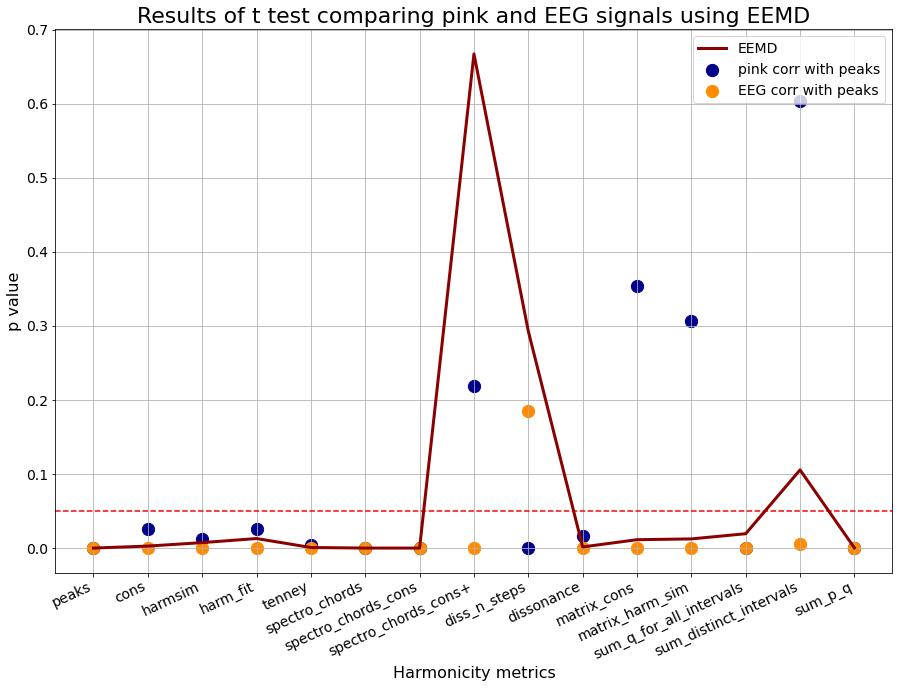

In [7]:
ttest_all_EEG_pink = ttest_all_metrics_all_functions(pink_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_pink, function, labels = ['pink', 'EEG'], 
                           peaks_corr1=peaks_corr_pink, peaks_corr2=peaks_corr_EEG, color=color, save=True)

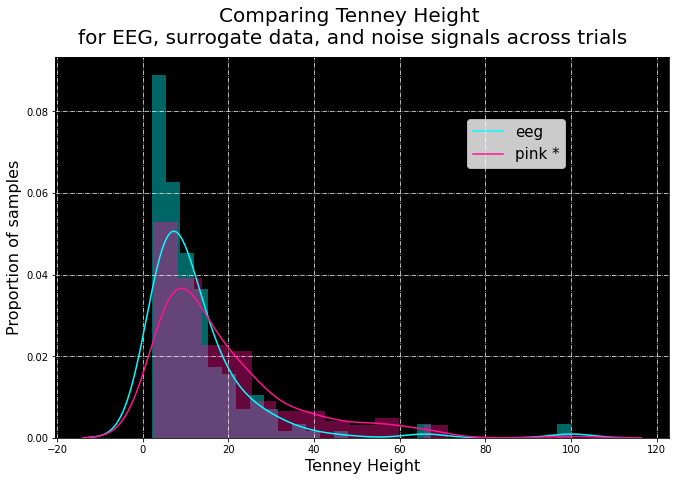

In [13]:
test_graph = [EEG_metrics[4]['harmsim'], pink_metrics[4]['harmsim']]
graph_dist(test_graph, metric = 'tenney', ref = test_graph[0], dimensions = [0], labs = ['eeg', 'pink'], 
           savefolder = '\\', subject = '0', tag = '0', adapt = 'False', 
           peaks_function = 'HH1D_max', colors = None, display = True, save = False, title=None)

## Which harmonicity metrics best distinguish between EEG signal and surrogate data using phase randomization ?

In [526]:
phase_data = surrogate_signal_matrices(EEG_data[0:250, 2000:7000], surr_type = 'phase', low_cut = 0.5, high_cut = 150, sf = 1000)

In [527]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['HH1D_max', 'harmonic_peaks', 'fixed', 'adapt', 'EMD', 'EEMD', 'FOOOF']
peaks_corr_phase, phase_metrics = compare_corr_metrics_peaks(phase_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

phase_metrics = np.array(phase_metrics)
EEG_metrics = np.array(EEG_metrics)

HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF
HH1D_max
harmonic_peaks
fixed
adapt
EMD
EEMD
FOOOF


In [528]:
np.save('peaks_corr_EEG_0.5_w-phase.npy', peaks_corr_EEG)
np.save('peaks_corr_phase_0.5.npy', peaks_corr_phase)

np.save('EEG_metrics_0.5_w-phase.npy', EEG_metrics)
np.save('phase_metrics_0.5.npy', phase_metrics)

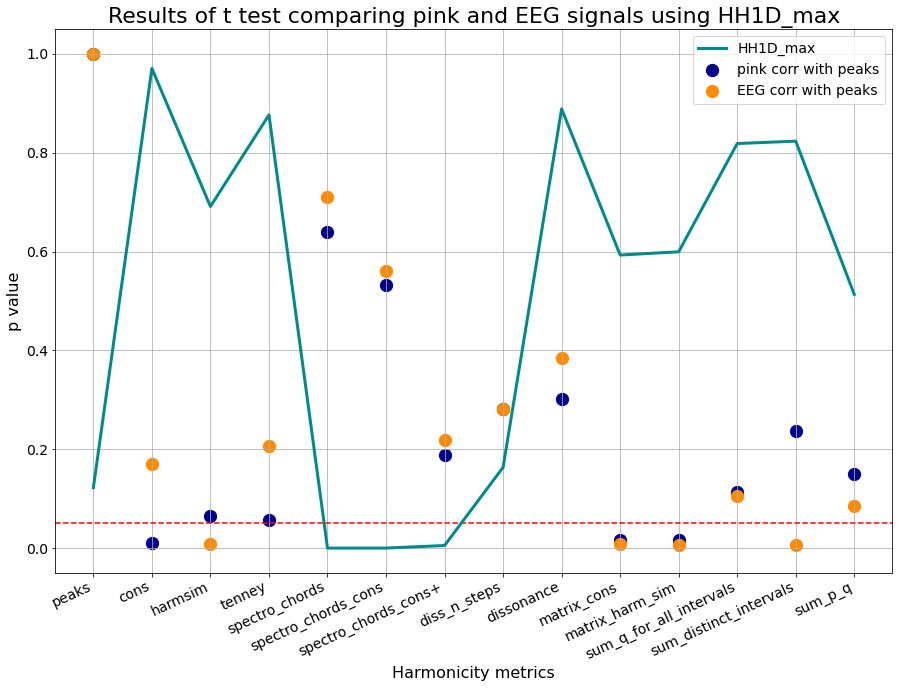

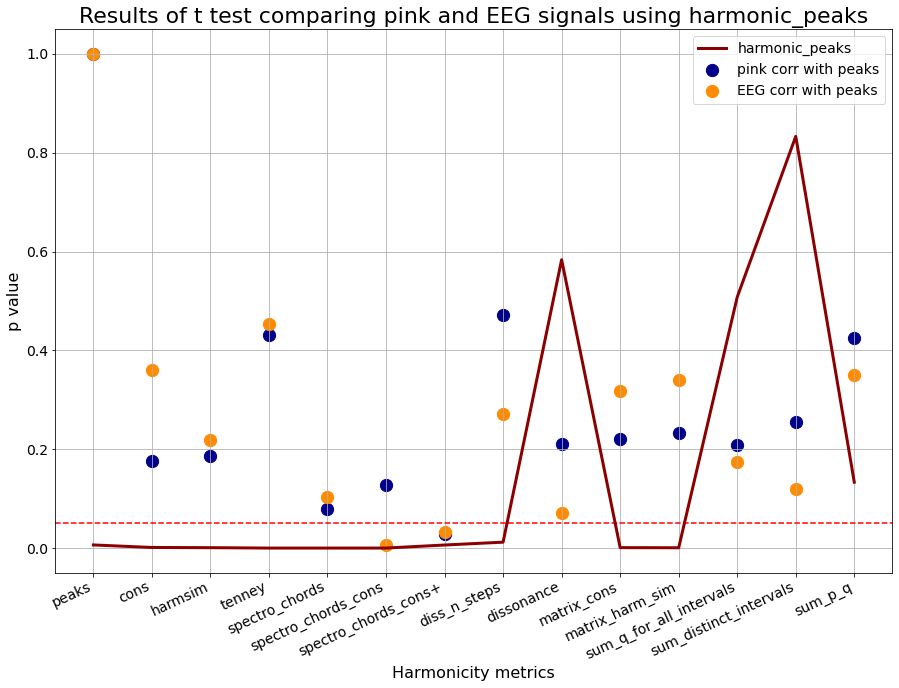

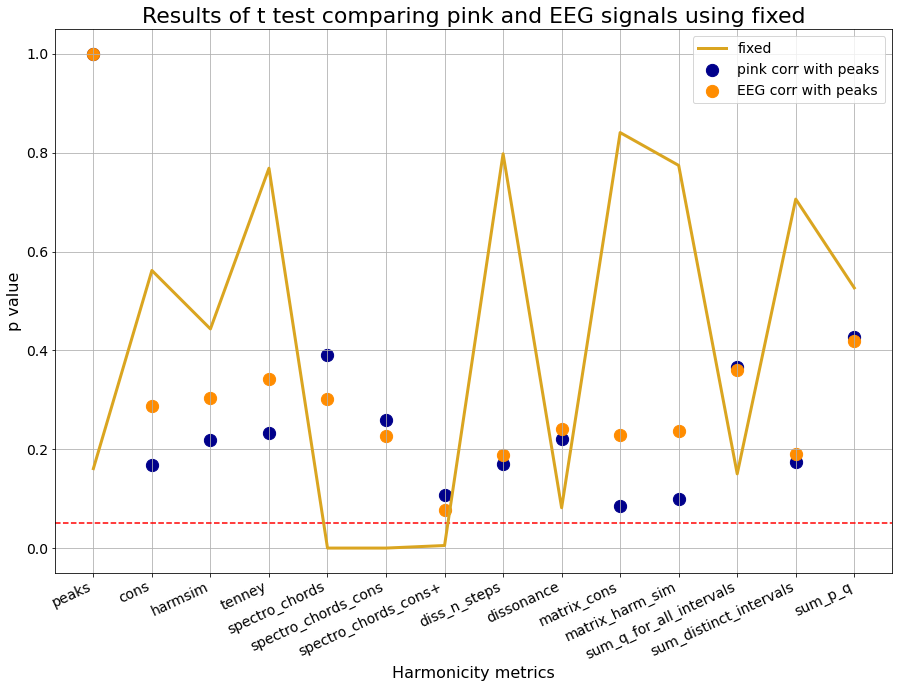

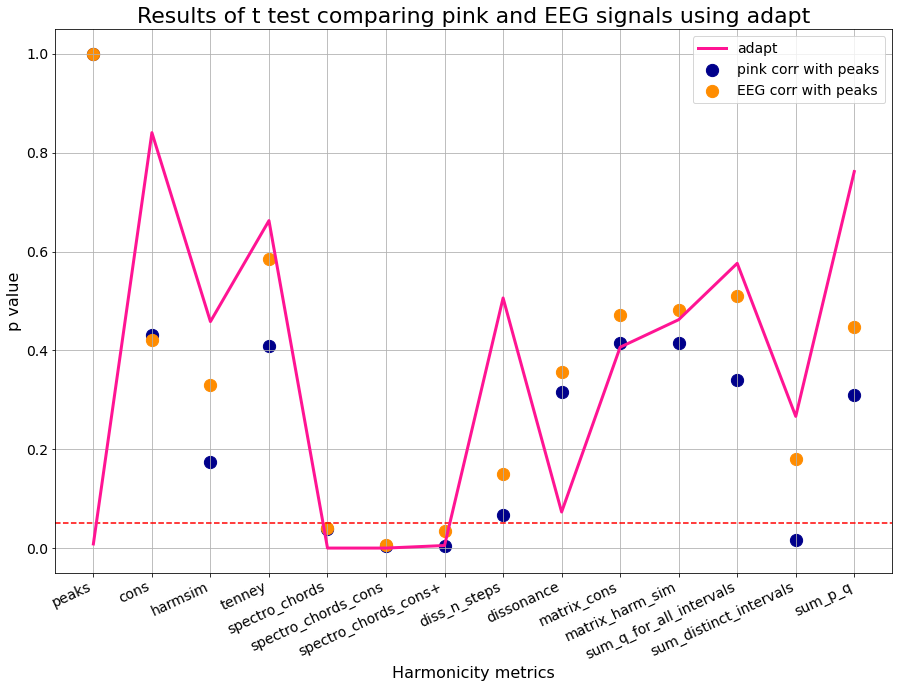

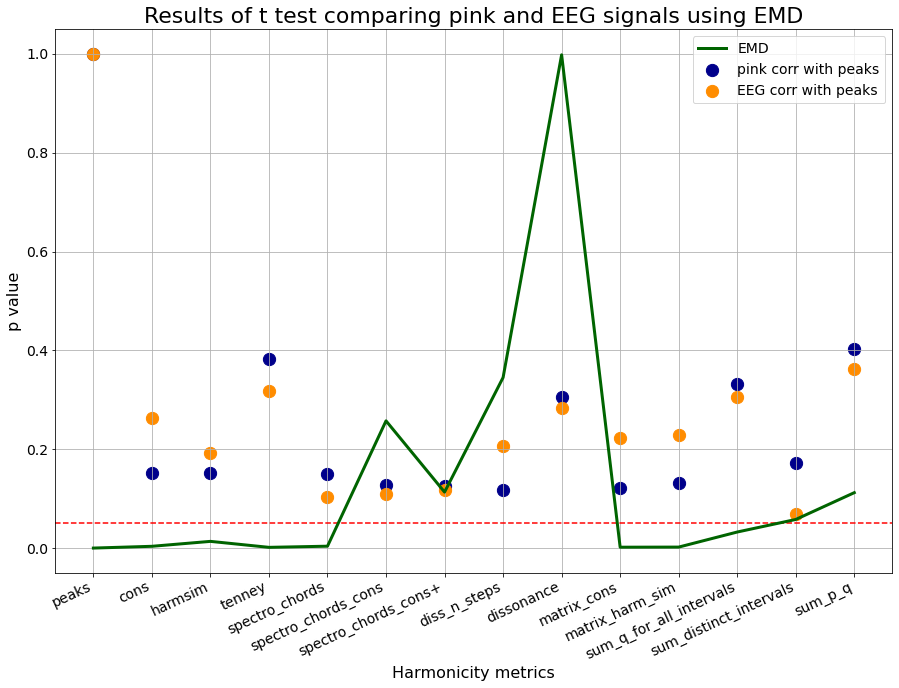

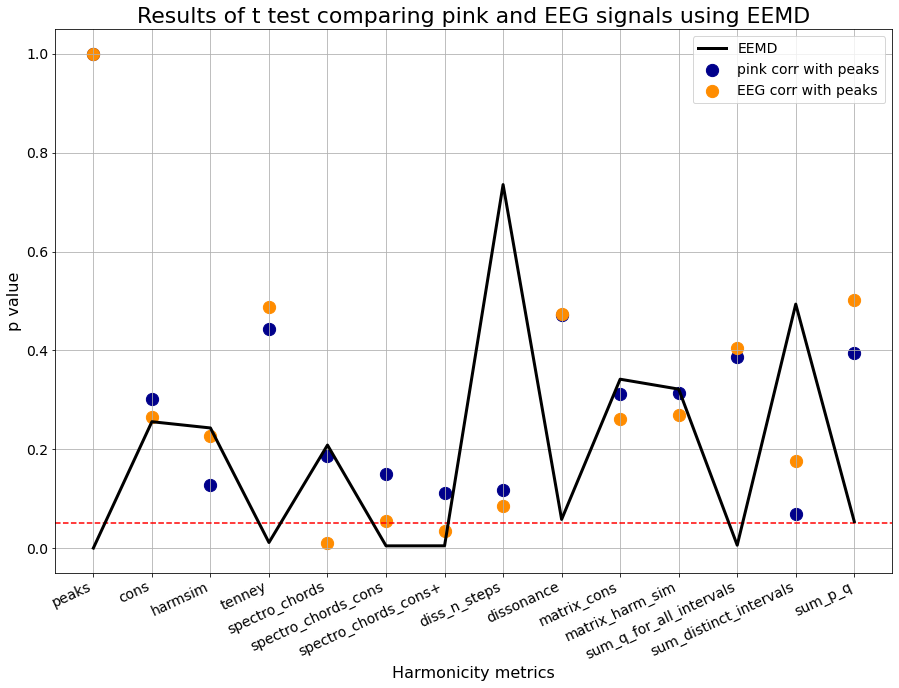

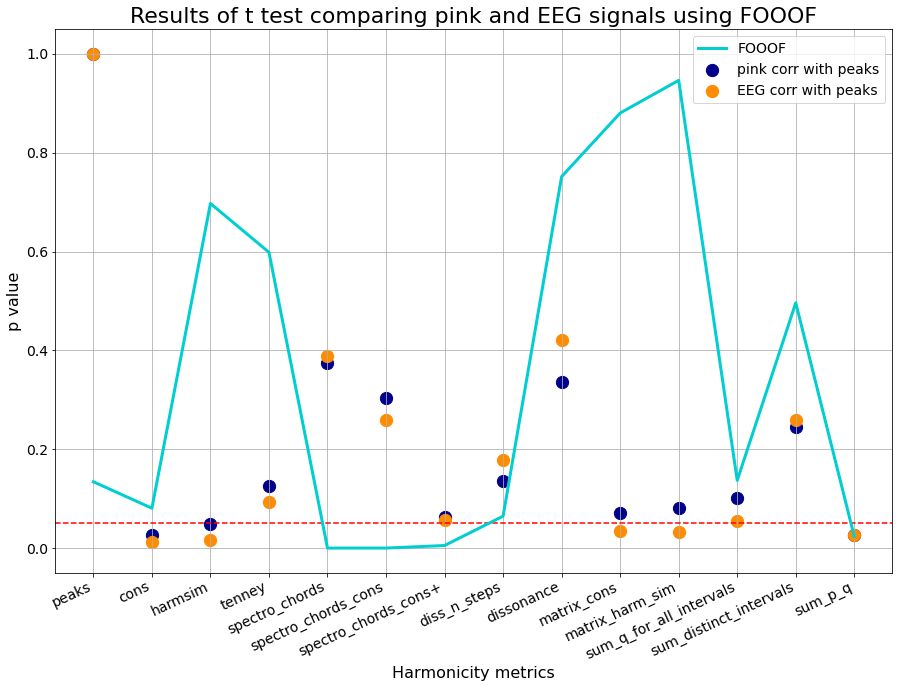

In [530]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all_EEG_phase = ttest_all_metrics_all_functions(phase_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_phase, function, labels = ['pink', 'EEG'], 
                           peaks_corr1=peaks_corr_phase, peaks_corr2=peaks_corr_EEG, color=color, save=True)

In [3]:
AAFT_data = surrogate_signal_matrices(EEG_data[0:250, 2000:7000], surr_type = 'AAFT', low_cut = 0.5, high_cut = 150, sf = 1000)

In [4]:
AAFT_data.shape

(250, 5000)

In [4]:
FREQ_BANDS = [[2, 4], [4, 8], [8, 16], [16, 32], [32, 64]]
peaks_functions=['FOOOF_EEMD', 'fixed', 'adapt', 'cepstrum', 'harmonic_peaks', 'FOOOF', 'HH1D_max']#, 'EMD', 'EEMD'
peaks_corr_AAFT, AAFT_metrics = compare_corr_metrics_peaks(AAFT_data, 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

#AAFT_metrics = np.array(AAFT_metrics)

#np.save('peaks_corr_AAFT_0.5.npy', peaks_corr_phase)
#np.save('AAFT_metrics_0.5.npy', phase_metrics)

FOOOF_EEMD
[ 1.   26.94  9.73  4.01  2.29]
[ 1.5  19.25  8.81  6.04  3.  ]
[ 1.34 26.68 10.54  6.52  3.34]
[ 1.18 25.77 12.17  5.77  2.51]
[34.14 27.13 12.36  5.47  2.59]
[ 3.   21.05 10.26  5.57  3.1 ]
[25.7  22.31  9.22  6.51  2.43]
[ 1.22 20.68  9.64  5.05  3.86]
[36.57 27.01 10.38  5.76  3.95]
[ 2.17 23.   15.27  7.24  3.25]
[28.3  13.85  9.99  5.16  1.98]
[29.51 16.77 12.95  5.57  1.86]
[31.5  23.87 11.78  5.29  2.06]
[ 1.   26.99 11.61  6.42  3.62]
[ 0.5  20.76 10.05  8.03  3.03]
[ 0.95 21.26  9.    6.46  3.14]
[31.44 14.65 10.93  4.27  3.08]
[ 0.68 17.03 11.6   4.12  2.88]
[29.04 20.26  9.64  4.5   1.99]
[40.99 21.46 20.16  6.41  2.5 ]
[41.33 28.51 13.75  6.32  3.47]
[43.76 21.04 13.94  9.18  4.63]
[39.03 31.65  9.96  8.26  3.83]
[41.16 29.45 11.25  9.19  3.14]
[ 1.16 13.75  9.14  6.46  2.44]
[38.79 18.93  9.77  5.86  3.09]
[ 2.   25.77 11.43  9.02  3.15]
[36.08 18.46  8.66  6.82  2.78]
[28.82 15.7  12.03  4.5   2.49]
[ 2.5  20.84  8.56  8.67  3.2 ]
[29.78 20.44 10.61  4.8   2.4

[ 3.5  6.   8.  21.5 49. ]
[ 2.   6.5 10.  28.5 32. ]
[ 3.5  6.  13.5 17.  34.5]
[ 2.  6.  8. 27. 34.]
[ 2.   6.   9.5 19.5 56.5]
[ 2.   6.   9.5 20.5 41. ]
[ 2.   6.  10.  30.5 52. ]
[ 2.   6.5 10.  21.5 32. ]
[ 3.   6.   8.5 29.5 33.5]
[ 2.   6.   8.5 19.5 33.5]
[ 3.   6.   8.  20.5 49. ]
[ 2.   6.  10.  31.  46.5]
[ 3.   5.5  8.5 21.5 33.5]
[ 3.5  4.   9.  26.5 43. ]
[ 2.   6.   9.  29.5 41. ]
[ 3.5  6.   8.  21.5 46. ]
[ 2.   4.   8.5 21.5 62.5]
[ 3.   4.  11.5 17.5 38. ]
[ 2.5  6.5  9.  18.  38. ]
[ 2.   4.   9.  17.5 32.5]
[ 2.   4.5  9.  16.  38. ]
[ 3.   6.5  8.  16.  48.5]
[ 3.5  4.  10.  20.  45. ]
[ 2.   6.  11.5 27.  61. ]
[ 2.5  6.   9.5 29.  32.5]
[ 2.   4.   9.  20.  38.5]
[ 3.  4. 10. 16. 35.]
[ 2.5  7.5  8.  16.  32. ]
[ 2.   7.5 11.5 31.  63. ]
[ 2.   6.5 10.  28.5 33. ]
[ 2.   7.   9.  28.5 55.5]
[ 2.5  6.5 11.5 31.5 33.5]
[ 2.   7.   9.5 23.  41.5]
[ 2.5  4.   9.5 16.  35. ]
[ 2.   4.  10.  16.  33.5]
[ 2.   4.  10.5 30.  32. ]
[ 2.   7.   8.  23.  33.5]
[ 2.   5.  

[ 2.   4.5 10.  18.5 32.5]
[ 2.   5.   9.5 19.  32.5]
[ 1.5  3.5  9.5 20.  30.5]
[ 2.   3.5  9.  19.  30. ]
[ 2.   4.5  9.  19.  29. ]
[ 1.5  3.5  9.  19.  32.5]
[ 2.   4.5 11.  18.  37. ]
[ 1.5  3.   7.5 13.  27. ]
[ 1.5  3.5  9.5 18.5 32. ]
[ 2.   4.5 10.  18.  32. ]
[ 2.   5.   9.  18.  29.5]
[ 2.   4.5  9.  14.5 29.5]
[ 2.  5. 11. 19. 50.]
[ 3.   5.5 11.5 20.5 50. ]
[ 1.5  3.   7.5 17.5 26. ]
[ 2.   5.5 10.  19.5 39. ]
[ 2.   5.5 10.  21.  32.5]
[ 2.   4.5 10.  17.  32. ]
[ 2.   3.5  9.  19.  30. ]
[ 2.5  4.5 10.  20.5 36.5]
[ 2.   4.5 10.5 20.5 37. ]
[ 2.5  5.  10.  18.5 36.5]
[ 2.   5.5 10.5 17.5 45.5]
[ 1.5  3.5  9.  19.  29.5]
[ 2.5  4.5 11.  26.5 51.5]
[ 2.5  5.  10.  20.  37. ]
[ 2.5  4.  10.5 17.5 37. ]
[ 2.5  5.  11.  17.5 50. ]
[ 2.5  4.5 10.5 19.  34.5]
[ 2.5  4.5 10.5 20.5 38. ]
[ 2.5  4.  10.5 17.5 36. ]
[ 1.5  3.   7.5 15.5 25.5]
[ 2.5  4.  10.5 17.  37. ]
[ 2.5  4.5 10.5 17.5 36.5]
[ 2.5  4.5 10.5 19.  37. ]
[ 2.5  4.  10.5 20.5 45.5]
[ 2.5  5.  10.5 18.  38. ]
[ 1.5 

[15.38 10.31  6.37  4.88  5.29]
[24.39 14.93 10.1   6.45  5.41]
[24.39 14.93 10.75  7.3   6.45]
[24.39 15.87  9.01  6.37  3.58]
[34.48 17.54 14.49 10.99  9.35]
[24.39 13.7   9.9   7.87  6.29]
[14.08 10.1   6.29  3.64  4.22]
[24.39 14.49  9.17  6.37  5.35]
[23.26 16.39  9.17 10.75  6.45]
[23.26 16.39 12.99  9.17 10.75]
[13.7  10.75  8.    6.21  5.08]
[24.39 14.08 10.31  8.    6.21]
[24.39 14.08  9.17 10.53  7.09]
[23.26 14.93  9.17  7.19  6.29]
[23.26 16.39  9.17  7.19  6.37]
[40.   13.7   9.9   7.09  6.29]
[40.   16.39  9.35  8.13  4.83]
[23.26 16.39  9.17 10.31  6.29]
[23.26 16.39  9.17  6.37  5.78]
[22.22 16.95  9.01  6.45  5.71]
[24.39 17.54  9.35  6.37  3.44]
[24.39 15.38  9.52  8.13  7.09]
[25.64 16.95 13.33  9.52  7.87]
[34.48 15.87  9.35  8.    6.29]
[16.95  9.35  6.29  5.65  4.83]
[22.22 16.39  9.35  8.    6.37]
[25.64 17.54  9.52  6.29  5.59]
[30.3  15.38  8.    9.17  6.8 ]
[16.39 10.99  9.17  6.29  5.71]
[16.95 10.1   6.06  4.78  5.29]
[32.26 17.54  9.35  6.21  4.78]
[16.39 1

[18. 30.]
[48.]
[ 6. 25.]
[18.5]
[12.5 17.5 25.  35.5 49.  55.5]
[12. 18. 40. 48.]
[ 9.5 18.  38. ]
[10. 25. 30.]
[ 9.  18.5 37. ]
[ 9. 27.]
[ 6.  12.5 29. ]
[ 4.5 12.5]
[ 6. 18. 35. 41. 49.]
[13.5 40.5]
[ 4.  9. 44.]
[ 3. 10. 39. 44.]
[ 5.5 15.5 21.  59.5]
[ 7.5 12.5]
[12.5 19.5 51.5]
[ 6.5 18.  47.5]
[13. 19. 29. 39. 52. 58.]
[38.]
[ 2.5 59. ]
[ 9.5 15.  24.  29.  40.  57. ]
[ 5.5 13.  25.5 42.5]
[ 2.5 25.  32.5]
[ 2.5 18.5]
[ 2.5 19. ]
FOOOF
[ 8.96 10.74  6.31 27.07 29.67]
[ 6.09  8.98  8.51 23.21 12.78]
[ 8.79 26.86  5.88 21.34 12.19]
[ 5.91 33.8  12.39  9.94 42.73]
[34.1  29.45 12.09 38.79 27.14]
[29.34 38.64  6.57 10.84 34.  ]
[ 6.14  8.71 26.83 33.69 29.26]
[ 6.07  9.37 20.85 27.   29.58]
[20.76 27.22 22.96  6.04 29.58]
[22.99 30.3  20.32 40.62  7.46]
[ 9.67 29.21 13.42  6.19 20.38]
[16.87 29.49 31.43 27.2  13.81]
[ 6.07  9.63 34.1  29.5  31.43]
[ 6.13  9.2  26.97 29.42 42.88]
[ 6.15 20.73  8.13 40.95 39.43]
[30.3   6.2  28.25 40.47 21.3 ]
[10.13 12.52 14.33 28.13 21.79]
[29.49 

[15.98  2.83  5.83  9.87 18.62]
[40.22 19.75  9.26 14.99 18.33]
[19.23  9.11 29.26 42.63  5.74]
[18.31 32.2   2.26 25.17  6.51]
[39.04 18.87  5.58 33.51 15.96]
[18.43  6.06 15.12  2.85 30.24]
HH1D_max
[ 2.22  3.14  7.23 23.53 43.93]
[ 2.22  5.48  7.75 21.95 40.99]
[ 2.55  6.29  8.9  27.03 57.99]
[ 1.68  5.11  7.75 27.03 54.1 ]
[ 1.68  2.55  9.54 21.95 43.93]
[ 1.57  2.93  8.31 19.1  40.99]
[ 2.07  5.11  8.31 28.97 54.1 ]
[ 1.93  5.11  8.9  25.22 54.1 ]
[ 2.22  6.75  8.9  27.03 57.99]
[ 3.14  5.87 12.6  23.53 57.99]
[ 1.47  2.22  8.9  14.47 35.68]
[ 1.47  3.14  8.31 19.1  40.99]
[ 1.8   1.47  7.75 23.53 35.68]
[ 2.93  5.48 10.23 23.53 57.99]
[ 1.37  6.29  9.54 23.53 57.99]
[ 1.28  2.74 10.97 23.53 54.1 ]
[ 1.28  3.61  9.54 14.47 54.1 ]
[ 1.28  3.61  9.54 17.82 54.1 ]
[ 1.57  5.11  8.31 23.53 54.1 ]
[ 2.07  5.48  8.31 31.05 57.99]
[ 3.14  7.23 16.63 28.97 54.1 ]
[ 1.28  4.45 10.23 25.22 57.99]
[ 2.07  6.75  9.54 28.97 50.47]
[ 1.11  5.48  9.54 31.05 47.09]
[ 2.07  3.14  7.75 31.05 57.99]

In [5]:
peaks_corr_AAFT

FOOOF_EEMD   fixed   adapt cepstrum harmonic_peaks  \
peaks                          0.0     0.0     0.0      0.0            0.0   
cons                        0.2403  0.0015     0.0   0.2093         0.0002   
harmsim                     0.1741     0.0  0.0003   0.4517            0.0   
harm_fit                       0.0     0.0     0.0      0.0         0.4222   
tenney                         0.0  0.0003     0.0      0.0            0.0   
diss_n_steps                0.0028  0.0008  0.0376   0.2038            0.0   
dissonance                     0.0     0.0     0.0      0.0         0.6846   
matrix_cons                  0.801  0.1141     0.0   0.6875         0.0007   
matrix_harm_sim             0.5137  0.0689     0.0   0.9399         0.0004   
sum_q_for_all_intervals        0.0     0.0     0.0      0.0         0.0004   
sum_distinct_intervals         0.0  0.0391  0.2577      0.0         0.0208   
sum_p_q                        0.0     0.0     0.0      0.0            0.0   

                          FOOOF HH1D_max  
peaks                       0.0      0.0  
cons                       0.14   0.3412  
harmsim                  0.0127   0.2542  
harm_fit                    0.0      0.0  
tenney                   0.1895   0.3333  
diss_n_steps             0.2042   0.0097  
dissonance               0.1773      0.0  
matrix_cons              0.1238   0.0294  
matrix_harm_sim          0.0833   0.0344  
sum_q_for_all_intervals  0.0675   0.0014  
sum_distinct_intervals   0.0001   0.0003  
sum_p_q                  0.6983   0.0264

In [6]:
peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

#EEG_metrics = np.array(EEG_metrics)

FOOOF_EEMD
[29.57 20.01 11.21  5.84  3.43]
[31.5  20.14  9.26  5.88  3.  ]
[43.51 26.93  8.63  8.01  3.19]
[40.29 33.51  9.72  4.42  2.43]
[38.74 26.93 14.    5.77  4.9 ]
[ 1.   26.92  8.53  5.79  4.82]
[32.06 26.93  9.52  6.23  3.42]
[43.17 27.24  9.83  3.96  3.36]
[29.19 23.08  9.72  4.75  5.43]
[22.55 16.96 14.07  6.08  3.34]
[21.91 10.9  10.11  7.37  3.2 ]
[29.42 26.89 12.11  8.07  3.78]
[25.61 26.99  8.65  6.25  3.12]
[31.14 18.51 17.04  8.23  3.96]
[39.53 20.33  8.31  5.89  3.98]
[28.13 15.92 13.79  5.97  2.58]
[33.26 12.85 11.02  3.75  1.88]
[25.9  26.79 10.05  8.83  3.  ]
[ 0.61 29.56  9.41  5.95  3.69]
[40.91 26.96  8.5   6.37  3.46]
[ 2.3  30.99 13.89  5.72  3.08]
[27.55 20.98  9.79  6.03  2.79]
[31.89 26.81  9.15  7.05  4.1 ]
[40.66 20.65  9.5   6.5   3.48]
[38.58 27.14  9.63  7.65  3.28]
[43.19 22.64 19.11 10.06  2.74]
[25.16  8.8  10.9   6.88  2.44]
[28.98 11.91 15.56  6.62  2.42]
[24.09 16.14 14.04  6.5   3.59]
[37.69 11.82 12.9   7.11  3.78]
[20.53 15.65 10.14  3.33  2.2

[ 2.   7.   8.  23.  51.5]
[ 2.   7.  10.  28.5 32. ]
[ 3.   4.5 13.5 31.5 34.5]
[ 2.   6.   8.  29.5 33.5]
[ 2.   6.   8.5 20.5 33.5]
[ 3.5  6.   8.  20.5 39.5]
[ 3.5  7.  10.  21.5 51.5]
[ 2.   4.  10.  21.5 33. ]
[ 3.5  4.   8.  29.5 33.5]
[ 3.5  4.   8.  29.5 33.5]
[ 3.5  4.   8.  27.  33.5]
[ 3.5  4.  10.  21.5 55.5]
[ 3.5  4.  10.  21.5 33. ]
[ 3.5  4.   9.  31.5 46.5]
[ 3.5  4.   8.  31.5 46. ]
[ 3.5  4.   8.  21.5 44. ]
[ 3.5  4.  10.  21.5 63.5]
[ 3.   5.5 11.5 30.  38. ]
[ 2.   6.5  9.5 29.  38. ]
[ 2.   6.5  9.  16.  38. ]
[ 3.  4. 12. 16. 35.]
[ 3.5  4.  10.  28.  35. ]
[ 3.   7.5 10.  19.5 37. ]
[ 2.5  6.5 11.5 29.  61. ]
[ 2.5  6.5  9.5 30.5 38. ]
[ 3.5  6.5 11.  16.  44. ]
[ 2.5  4.  10.  16.  35. ]
[ 3.5  4.  10.  19.5 34.5]
[ 2.   7.  11.5 31.5 55. ]
[ 2.5  4.  11.5 16.  61. ]
[ 2.   6.5 11.  30.  61. ]
[ 2.5  4.  11.5 31.5 32. ]
[ 2.5  4.  11.  16.  35. ]
[ 3.5  4.   9.5 16.  46.5]
[ 2.  4. 10. 16. 44.]
[ 2.5  4.  11.5 29.5 32.5]
[ 2.5  4.   8.  16.  35. ]
[ 2.5  4.  

[ 2.5  4.5 11.5 20.5 39. ]
[ 1.5  3.5  9.5 19.5 32.5]
[ 2.   3.5  9.5 19.5 32.5]
[ 1.5  4.5  9.5 20.5 32.5]
[ 2.   4.5  9.5 20.5 33. ]
[ 2.   5.   9.5 20.5 32.5]
[ 2.   3.5  9.5 20.5 32.5]
[ 2.   6.  10.5 19.  39.5]
[ 1.5  3.   7.5 12.  26. ]
[ 1.5  3.   7.5 13.  28. ]
[ 1.5  4.5  9.5 18.5 39. ]
[ 2.   4.5  9.5 20.5 33. ]
[ 2.   5.   9.5 20.5 33. ]
[ 2.   5.   9.5 20.5 33. ]
[ 1.5  3.5  9.5 20.  33. ]
[ 1.5  3.   7.5 12.  26. ]
[ 1.5  3.   7.5 13.  26. ]
[ 2.   4.5  9.  20.5 30. ]
[ 2.   5.   9.5 20.5 37. ]
[ 2.   3.5  9.5 20.5 33. ]
[ 1.5  3.   7.5 12.  26. ]
[ 1.5  3.   7.5 14.5 29.5]
[ 2.   3.5  9.  20.5 30. ]
[ 1.5  3.   7.5 12.5 26. ]
[ 1.5  3.5  9.5 20.5 33. ]
[ 1.5  3.5  9.5 15.5 31. ]
[ 2.5  4.5 11.  26.5 37. ]
[ 1.5  3.5  7.5 14.5 26.5]
[ 1.5  3.5  9.5 20.5 37. ]
[ 2.5  5.  10.5 18.5 45.5]
[ 1.5  3.5  9.5 15.5 31. ]
[ 1.5  3.   7.5 18.  26. ]
[ 1.5  3.   7.5 18.  25.5]
[ 1.5  3.   7.5 12.5 24. ]
[ 1.5  3.   7.5 17.  36.5]
[ 2.5  4.5 10.  17.  37. ]
[ 2.5  5.  10.5 18.5 36.5]
[

[25.64 15.38  9.35  6.29  4.29]
[25.64 15.38 10.1   7.19  6.54]
[24.39 14.49  9.17  7.3   6.45]
[24.39 14.93  9.17  7.19  6.37]
[23.26 15.38  9.9   7.19  6.37]
[34.48 16.95 14.08 10.99  8.13]
[14.08  9.71  7.87  6.21  5.08]
[13.7   9.17  6.37  5.78  5.03]
[24.39 14.49  9.17  7.09  6.29]
[23.26 16.39  9.17 10.75  8.13]
[23.26 13.33  8.13 10.75  7.19]
[13.7  10.75  8.    6.29  2.46]
[24.39 14.08 10.31  8.    6.29]
[24.39 14.08  9.17  8.    6.21]
[23.26 14.93  9.17  7.3   6.29]
[40.   23.26 16.39 10.99  9.17]
[13.7   9.9   6.29  5.65  3.46]
[40.   16.39 10.31  8.13  4.83]
[22.22 16.39 10.31  9.17  6.29]
[23.26 16.95  9.17  6.37  5.71]
[22.22 16.95 10.99  9.17  6.37]
[24.39 16.95  9.35  6.37  3.44]
[24.39 15.38  8.13  9.52  7.09]
[9.35 7.75 5.41 4.69 3.77]
[34.48 15.87  9.35  8.    6.99]
[16.95  9.35  6.29  4.83  4.12]
[22.22 16.39  9.35  6.37  4.78]
[27.03 17.54  9.52  6.29  5.18]
[15.38  9.17  6.29  5.18  3.46]
[16.39 10.99  9.35  8.    6.8 ]
[32.26 21.28 16.95  9.17  6.8 ]
[32.26 16.95 

[ 7.  25.  32.5 56.5]
[13.  18.  33.5 39. ]
[ 7.  18.  28.5]
FOOOF
[ 6.07  8.81 10.47 26.94  4.42]
[ 5.93  9.19 26.91 29.49 33.45]
[ 5.98  9.15 26.25 29.42 31.9 ]
[33.55  6.02  8.94 42.81 28.54]
[29.43 33.93 27.13 31.45 39.05]
[ 6.06  9.17 26.99 33.54 29.37]
[ 6.03  8.44 26.95  9.84 31.62]
[ 5.99 26.97  9.19 20.54 40.02]
[ 6.06 23.11 26.8  20.58 29.74]
[30.09  6.28 21.43 25.55 40.83]
[10.16 29.1  13.9   5.64]
[27.15 16.9  29.42 31.4  13.79]
[ 6.04 27.07  9.47 29.37 33.68]
[ 6.03  8.74 29.4  26.9  20.36]
[ 6.06 20.44 30.31  9.12 40.87]
[29.45  6.11 40.79  9.48 21.31]
[10.08 28.27 30.67 14.2   6.25]
[29.32 27.07 31.58 38.67  9.32]
[ 6.05 29.27  9.31 27.01 31.55]
[ 6.01 40.99 29.15 20.59  9.17]
[ 6.2  30.5   9.17 40.82 20.9 ]
[ 9.82 28.49 30.77 13.56  6.28]
[ 8.88 31.56 29.29  6.18 11.81]
[40.83  9.02 29.26 31.56 26.91]
[ 6.11 39.13 21.    8.98 24.55]
[ 6.3  42.48 21.21  9.52 30.9 ]
[37.86  2.96 33.74 29.93 11.27]
[ 1.   38.08  2.89 29.57 33.87]
[38.37 15.64 29.29 32.93 18.12]
[29.75 15.4

[ 2.07  5.87  7.75 27.03 38.24]
[ 2.38  4.15  4.15 27.03 54.1 ]
[ 2.38  3.87  5.87 25.22 54.1 ]
[ 1.57  4.77  8.31 23.53 54.1 ]
[ 2.55  7.23  8.31 23.53 54.1 ]
[ 1.68  1.8  11.75 11.75 54.1 ]
[ 2.07  7.75 11.75 21.95 35.68]
[ 2.55  6.29  8.31 23.53 57.99]
[ 1.93  6.29 11.75 31.05 57.99]
[ 2.74  6.75  6.75 21.95 54.1 ]
[ 2.38  5.87  8.31 25.22 57.99]
[ 1.57  3.37  6.75 10.97 57.99]
[ 3.14  2.93 14.47 28.97 57.99]
[ 2.38  2.38  8.31 23.53 57.99]
[ 3.14  5.48  7.23 27.03 57.99]
[ 2.07  7.75 10.97 25.22 57.99]
[ 1.57  3.87  5.11 23.53 54.1 ]
[ 3.61  2.55  8.9  35.68 57.99]
[ 1.28  3.37  9.54 25.22 50.47]
[ 2.93  7.75  6.75 28.97 57.99]
[ 1.8   5.87  8.9  25.22 54.1 ]
[ 1.68  3.61 10.97 19.1  54.1 ]
[ 2.22  2.74  8.9  27.03 57.99]
[ 1.11  4.15  9.54 25.22 47.09]
[ 1.8   5.87  8.31 23.53 57.99]
[ 1.04  1.57  2.93 16.63 21.95]
[ 1.28  5.87  8.9  19.1  21.95]
[ 1.47  6.29  8.31 27.03 57.99]
[ 1.93  4.15 13.5  33.28 57.99]
[ 1.57  5.11  8.9  25.22 54.1 ]
[ 1.93  3.61  7.75 14.47 27.03]
[ 1.57  

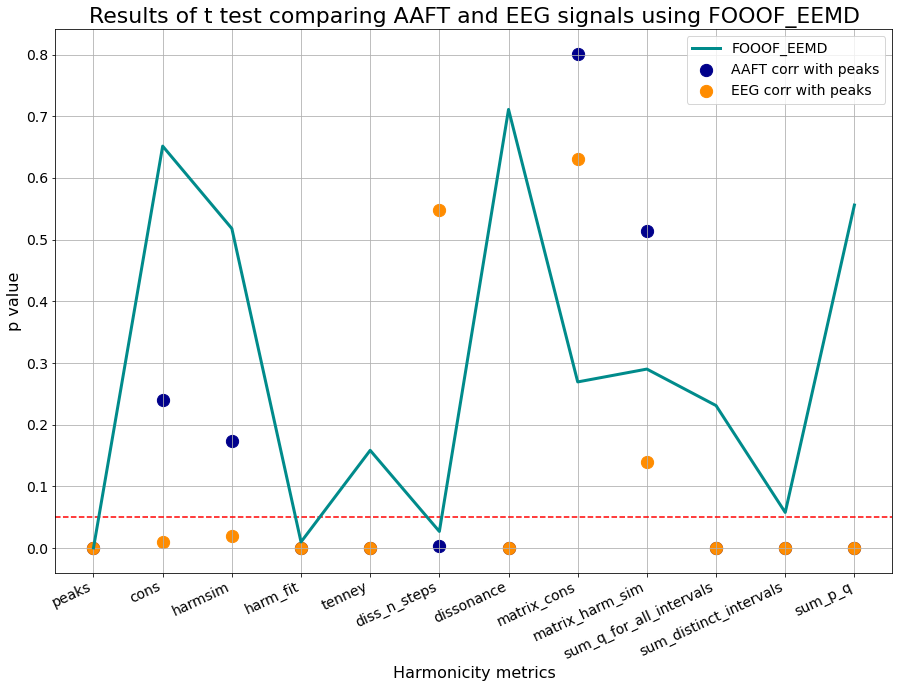

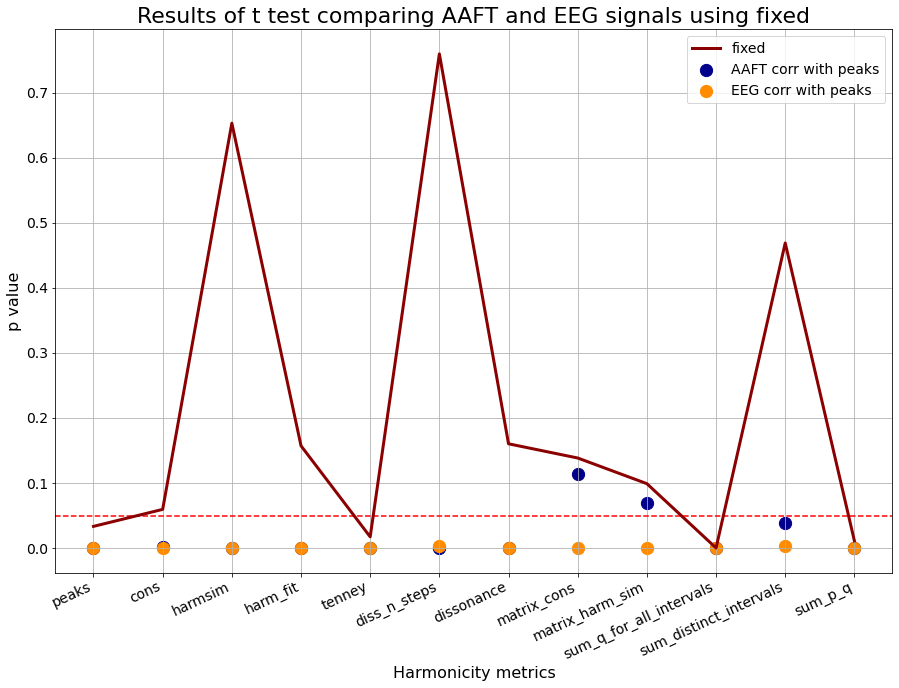

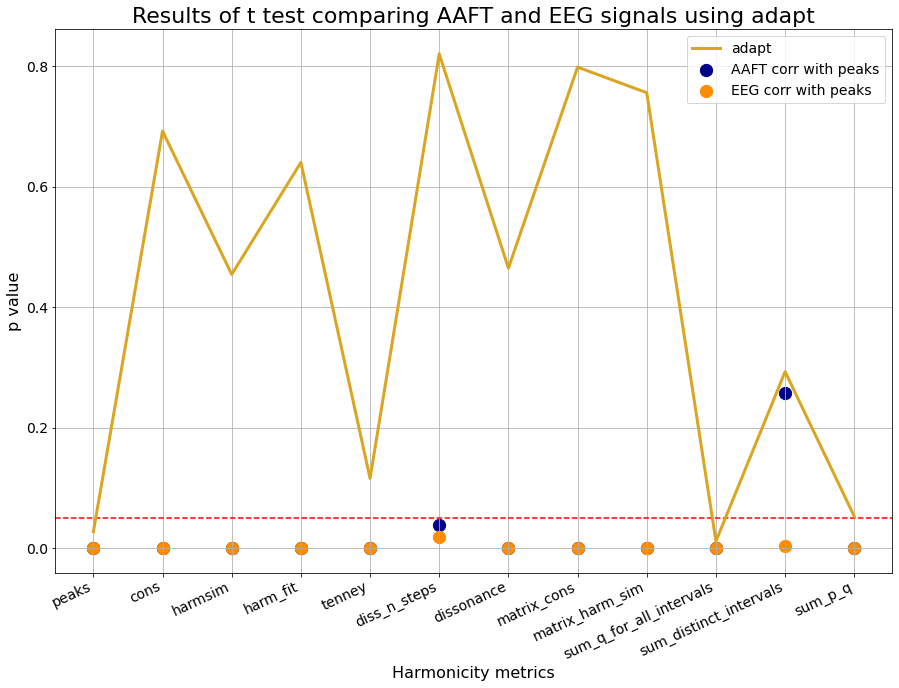

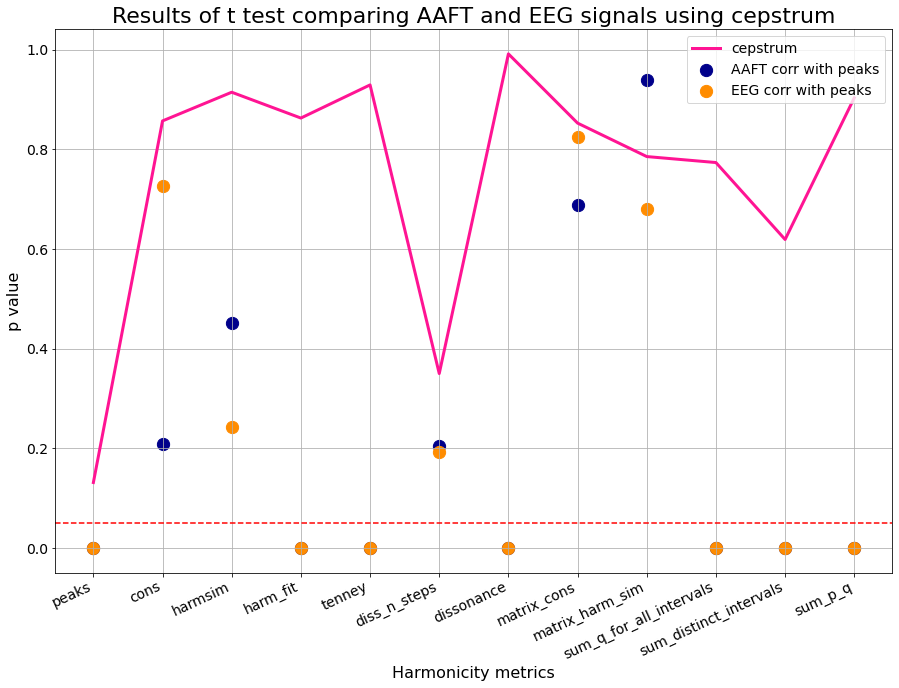

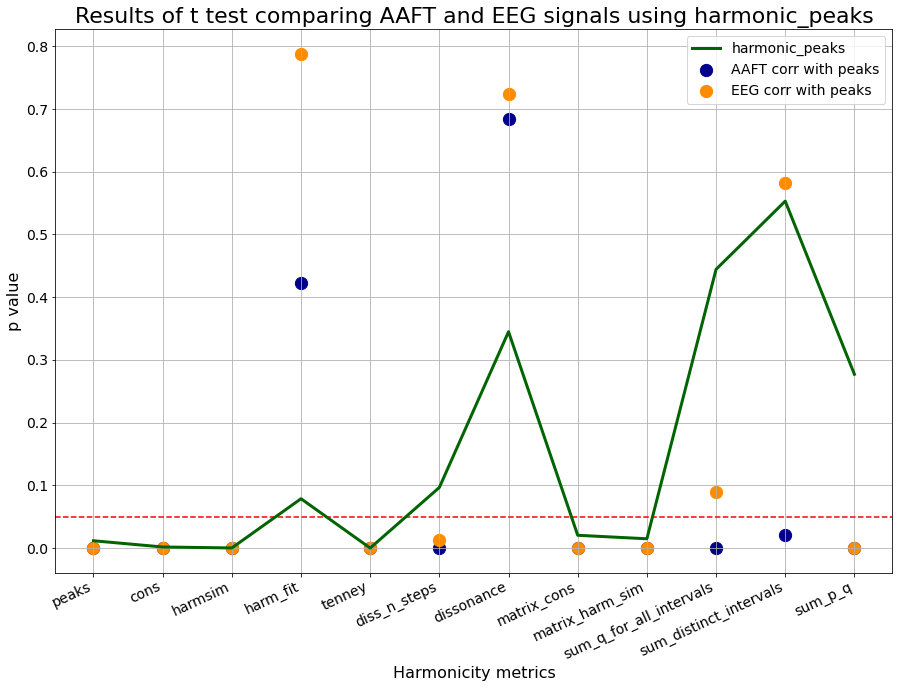

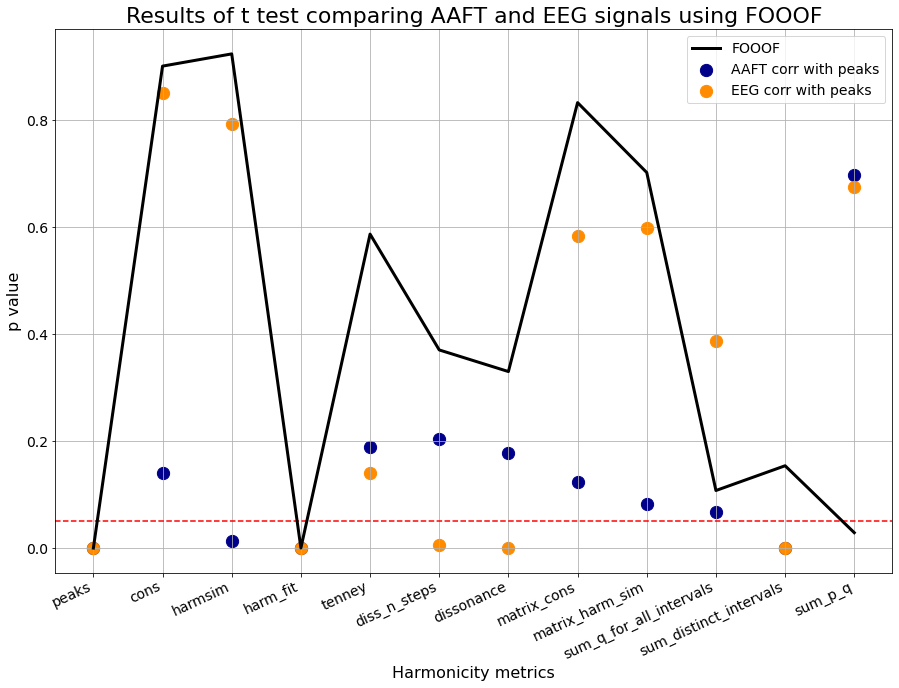

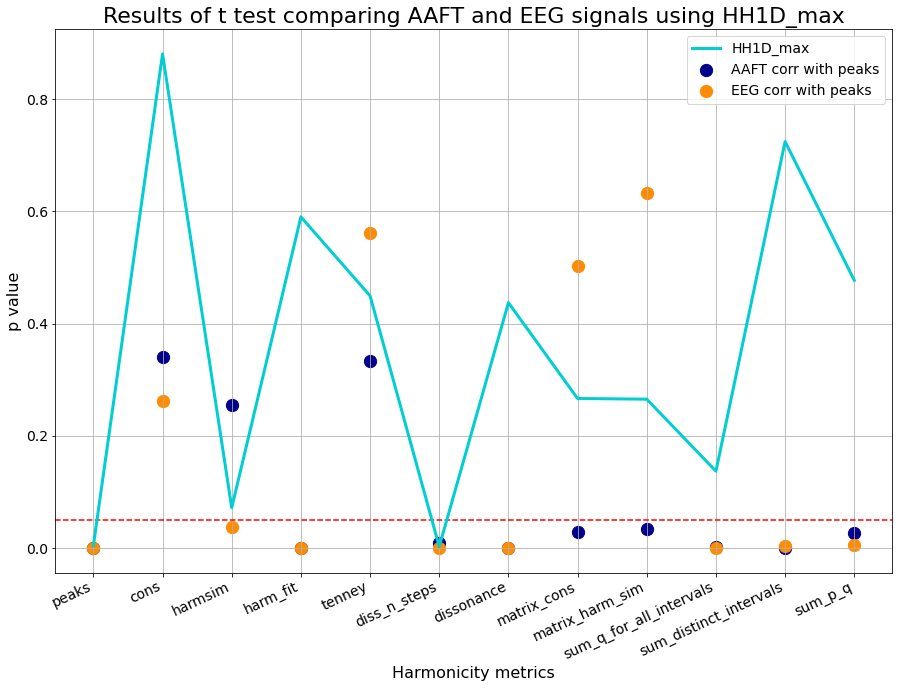

In [7]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all_EEG_AAFT = ttest_all_metrics_all_functions(AAFT_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_AAFT, function, labels = ['AAFT', 'EEG'], 
                           peaks_corr1=peaks_corr_AAFT, peaks_corr2=peaks_corr_EEG, color=color, save=True)

In [ ]:
peaks_corr_EEG, EEG_metrics = compare_corr_metrics_peaks(EEG_data[0:250, 2000:7000], 1000, 
                                                          peaks_functions=peaks_functions, 
                                                          precision=0.5, FREQ_BANDS = FREQ_BANDS,
                                                          min_notes=2, cons_limit=0.1, chords_multiple_metrics=True)

EEG_metrics = np.array(EEG_metrics)

HH1D_max
harmonic_peaks
fixed
adapt
EMD


In [ ]:
plt.rcParams['axes.facecolor'] = 'white'
ttest_all_EEG_AAFT = ttest_all_metrics_all_functions(AAFT_metrics, EEG_metrics, peaks_functions)
colors = ['darkcyan', 'darkred', 'goldenrod', 'deeppink', 'darkgreen', 'black', 'darkturquoise']
for function, color in zip(peaks_functions, colors):
    plot_ttest_all_metrics(ttest_all_EEG_AAFT, function, labels = ['pink', 'EEG'], 
                           peaks_corr1=peaks_corr_AAFT, peaks_corr2=peaks_corr_EEG, color=color, save=True)